![Swift for TensorFlow logo](images/swiftTensorFlowLogo.png)
# Building and Training an XResNet from Scratch, in Swift!
<br/>

#### Why did I make this notebook?
This notebook curates and distills the code presented in the [Swift notebooks](https://github.com/fastai/course-v3/tree/master/nbs/swift) of the 2019 fast.ai [part 2 course](https://course.fast.ai/part2) down to a bare minimum. I wanted to demonstrate how to implement, from scratch, only those pieces necessary to use Swift for TensorFlow to train an XResNet image classifier using modern training techniques.

Put differently, my inspiration here was to create a tight and easy-to-follow summary of the fast.ai course's Swift module. I also add text blurbs where I attempt to explain in my own words what certain parts of the code are doing and how they work.

The [PyTorch notebooks](https://github.com/fastai/course-v3/tree/master/nbs/dl2) of fast.ai's part 2 course introduced students to the components that lie at the heart of any deep learning framework, such as matrix multiplication, data loaders, and batch training. Each notebook helped students start with basic building blocks and work their way up to implementing robust versions of these components that perform just as well their PyTorch or fastai counterparts.

The course's [Swift notebooks](https://github.com/fastai/course-v3/tree/master/nbs/swift) attempt to do much the same, but in the Swift language. Having already fully reviewed all the PyTorch notebooks by the time I got to the Swift section, I felt like I already had a firm grasp of the fundamentals of how a data loader, training loop, or callbacks worked. What I really wanted at this point was a single pipeline that demonstrates, inside a single notebook, how to write the best version of a data loader, a training loop, batch norm, etc. in Swift, and then strings together all of these components to complete a meaningful task using a real dataset.

Since this kind of tight, linear and easy-to-follow walkthrough didn't yet exist, I decided to make my own right here! The Swift code that follows below is simply my re-implementation of *some* of the logic found in the Swift notebooks introduced in the final two lessons the 2019 part II fast.ai course.

#### Attribution
Virtually all the Swift code that appears in this notebook is the creation of [Sylvain Gugger](https://www.fast.ai/about/#sylvain) and [Jeremy Howard](https://www.fast.ai/about/#jeremy). The original versions can be found [here](https://github.com/fastai/course-v3/tree/master/nbs/swift), and with the execption of two of my own convenience modifications (also printing out training loss/accuracy in addition to validation stats during training, and a delegate that records and plots how momentum varied during training), all I did was re-type, line-by-line, the pieces of logic necessary to train the XResNet model in this notebook's [finale](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/13_swift_resnet_pipeline_s4tf_v04_my_reimplementation.ipynb#Training-an-XResNet34).

Some of the toy examples I used to introduce basic Swift concepts come from the [wonderful slides](https://docs.google.com/presentation/d/1dc6o2o-uYGnJeCeyvgsgyk05dBMneArxdICW5vF75oU) created by [Chris Lattner](http://nondot.org/~sabre/).

On the other hand, unless another source is explicitly credited, all long-form text explanations in this notebook are solely my own creation. Writing long-form explanations in plain and simple English forces me to make sure that I actually understand how the concepts and code work.

#### The rest of this notebook: what to expect
After an explanation of why it is worthwhile to take the time to learn how to do deep learning in Swift, I review some of the notable aspects of the Swift language and pay particular attention to areas where it differs from Python. Thereon, the remainder of the notebook is a singular journey toward building and training an XResNet model on the [Imagenette](https://github.com/fastai/imagenette) imageset, using only Swift for TensorFlow. 

I use Sylvain and Jeremy's code to demonstrate a complete pre-processing pipeline, as well as implementations of batchnorm, training loop callbacks, and modern bells and whistles such as the [one cycle training policy](https://arxiv.org/abs/1803.09820).

#### Requirements
This notebook's code cells were successfully run, start to finish, on Swift for TensorFlow [version 0.4](https://github.com/tensorflow/swift/blob/master/Installation.md#releases) on an Ubuntu 18.04LTS [AWS p2.xlarge](https://aws.amazon.com/ec2/instance-types/p2/) instance. CUDA version was 10.0 and the cuDNN version was 7.6.1 (though 7.5 and above should be fine). A working installation of [Swift-Jupyter](https://github.com/google/swift-jupyter) (which is just a Swift kernel for Jupyter notebooks) is also necessary. And while, to the best of my knowledge, Swift-Jupyter isn't yet versioned, I installed it by doing a git-pull on the repo somewhere toward the end of August, 2019.

## Why Swift for TensorFlow?

#### Problems with the current Python-based status quo
To understand why Swift for TensorFlow is interesting, let's look at three issues that plague our experience with deep learning frameworks that offer Python APIs, like PyTorch and TensorFlow:

1. While Python can be a joy to learn and code, it is famously slow. It's memory management is [not thread-safe](https://wiki.python.org/moin/GlobalInterpreterLock), and absent a lot of jumping-through-hoops and extra workarounds, it's not easy to get Python code to take advantage of multi-processor or multi-threaded systems. This matters to deep learning practitioners because aside from the valiant but still-incomplete efforts of [NVIDIA's DALI library](https://towardsdatascience.com/diving-into-dali-1c30c28731c0), most of our dataset preprocessing and augmentation is done not on the GPU, but on the CPU.

2. Furthermore, even when Python code does bring optimized performance, this is typically because the Python code is just serving as an API for a library that's actually written in C or C++. So if something that you fed into the Pythonic API causes the C/C++ library to throw an error, it is not likely that your Python debugger will be terribly helpful in isolating what went wrong and understanding what should be done instead.

3. In the same vein, the reason that our PyTorch or TensorFlow models train so rapidly on the GPU is because these libraries first convert our models' layers and modules into GPU-optimized implementations that NVIDIA has already written into its [cuDNN library](https://developer.nvidia.com/cudnn). Only after this happens, does the "cuDNN-ified" version of our model get sent to the GPU to get trained. What this means for deep learning experimenters is that if NVIDIA hasn't already baked into cuDNN the particular layer you want to use include in your model, you're pretty much stuck up a creek as far as getting your model to train efficiently on the GPU goes. And of course, the obvious paradox is that if you're trying to invent something brand-new, there's no way NVIDIA could have already added it to cuDNN. 

    What this also means for experimenters is that unless you're capable of writing native CUDA code (which you would use to write your own GPU-optimized implementations of new layer types not already in cuDNN), there are a relatively limited number of architectures and designs available for you to play with. For example, [as this paper describes](https://dl.acm.org/citation.cfm?id=3321441), it's only possible to get [capsule networks](https://arxiv.org/abs/1710.09829) to train on the GPU if they are implemented in a really unintuitive way that cobbles together a bunch of disparate PyTorch or TensorFlow operations:
    
    >* Materialize all of the 3x3 image patches (of 4x4
matrices), which with stride 2 almost doubles the
input size.
   * Shuffle this large tensor to rearrange dimension
order to suit the matrix multiplication operator.
   * Perform a large yet inefficient batch matrix multiplication (of many tall/skinny matrices).
   * Shuffle the data layout back.
   * Sum the resulting tensor over 3 (non-adjacent) dimensions.
    
   This causes capsule networks to take much longer to train and use GPU memory much less efficiently than CNNs. Frustratingly, it would seem that this ideally doesn't have to be the case, seeing as how capsule networks require far four-times fewer operations and sixteen-times fewer parameters than similar CNNs!

   Finally, and reminiscent of the problem of debugging code when an error is thrown by the underlying C or C++ library, there can also be times when the GPU's CUDA layer throws an error that is similarly inscrutable to the Python compiler with which the researcher interacts.

#### The promise of Swift for TensorFlow
To sum it up, as far as experimenting with deep learning models goes, Python can be slow, opaque, and inflexible. The open source [Swift for TensorFlow](https://github.com/tensorflow/swift) library, whose development is currently being led by [Chris Lattner](http://nondot.org/~sabre/) (the creator of the Swift language) and his team at Google, aims to solve all three of these problems by giving the user the ability to modify code at any layer of abstraction in between the highest-level framework APIs, and the compiler below. The idea is that Swift for TensorFlow will allow experimenters to dive as deep as necessary so that they can write the tweaks that will get their experimental models to behave in exactly the manner they hope. In this world, the pracititioner wouldn't have to jerry-rig high-level PyTorch or TensorFlow concepts together to get a capsule network model that will be efficiently trainable. Rather, if the highest level Swift for TensorFlow API doesn't offer the proper building blocks for making an efficient implementation of capsule networks, the practitioner can override lower-level defaults with their own custom primitives that will be read by the same compiler responsible for parsing the highest-level Swift for TensorFlow code.

Now just how does Swift for TensorFlow plan to accomplish this? The vision is to create a deep learning framework that uses a completely differentiable programming language which will one day soon serve as syntactic sugar for the still-in-development [MLIR compiler](https://github.com/tensorflow/mlir). MLIR, or "Multi-Level Intermediate Representation," is another open source project also being led by a team at Google that reports to Chris Lattner. 

(Sidenote: in addition to getting Swift started, Chris also created the [LLVM compiler](https://llvm.org/), which is currently used by numerous languages including C#, Julia, Lua, Objective-C, and Swift.)

The MLIR team hopes to define a *common* intermediate representation that's intended to sit in between any kind of hardware machine learning practitioners might conceivably use (GPUs, TPUs, etc.) and a high-level framework (such as Swift for TensorFlow) that the same practitioners would use to define their models. If this still seems vague, think of MLIR as possibly one day being the "LLVM" of the machine learning/data science world.

The Swift for TensorFlow team was [very thoughtful](https://github.com/tensorflow/swift/blob/master/docs/WhySwiftForTensorFlow.md#which-languages-fit-our-project-requirements) about weighing tradeoffs when deciding what language they thought would be the best one to sit on top of MLIR. They settled on a short-list of Swift, Rust, C++, and Julia, and ultimately chose Swift because they themselves were more familiar with it, and because it is easier to learn than C++ or Rust. 

Some fast.ai practitioners have [wondered](https://forums.fast.ai/t/lesson-13-2019-discussion-and-wiki/44414/13) why for the [2019 part II course](https://course.fast.ai/part2), fast.ai had chosen to experiment with Swift for TensorFlow instead of Julia. During lecture 6 of the course, Jeremy Howard [mentioned](https://youtu.be/3TqN_M1L4ts?t=556) that while all things considered, Julia would be a great alternative, he felt that Julia was perhaps too mature and that the Swift language's relative immaturity (it's only 5 years old as of 2019) was actually more of an advantage than a negative. He felt that contributors to the Swift for TensorFlow project would be able to have more influence in shaping the Swift language so as to best serve the future needs of deep learning experimenters. And that at the same time, it wouldn't be likely that the project would make the mistake of being too locked-in to the status quo of how deep learning frameworks currently function today. 

To sum things up, the Swift for TensorFlow team's goal is to create a completely differentiable programming language that will one day sit on top of the MLIR compiler, which itself is intended to be compatible with any hardware infrastructure a practitioner might want to utilize. By coupling Swift for TensorFlow to MLIR, the hope is also that practitioners will be able to make whatever high or low-level tweaks are necessary for them to be able to efficiently train any kind of neural net architecture that they conjure up. The Swift for TensorFlow team often refers to this as the goal of making a deep learning framework that's "[infinitely hackable](https://docs.google.com/presentation/d/1dc6o2o-uYGnJeCeyvgsgyk05dBMneArxdICW5vF75oU/edit#slide=id.g56e60a167a_25_20)."

However, MLIR is still under development and without an official release date. As of spring 2019, it's [at least a year away](https://docs.google.com/presentation/d/1dc6o2o-uYGnJeCeyvgsgyk05dBMneArxdICW5vF75oU/edit#slide=id.g58253914c1_3_0). So what has the Swift for TensorFlow team been working on in the meantime? Their focus has been on making the Swift language as differentiable as possible. Or in other words, they've been working on integrating automatic differentiation directly into the Swift language.

What is [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation)? It's nothing more than a software compiler having the ability to calculate the derivative of a numerical function that was written in the compiler's programming language. If you've ever written a neural network in PyTorch or TensorFlow, you know that although your code actually only explicitly outlines the architecture and layer order of a forward pass through the network, PyTorch/TensorFlow are nevertheless able to know how to calculate all layers' gradients during the backward pass in order to update weight values during training. This is possible because both the PyTorch and TensorFlow teams have worked hard to build auto-diff into their frameworks. Note, however, that in both PyTorch and TensorFlow auto-diff is happening deeper down inside some C++ code for which their Python front-ends merely serve as wrappers. As touched upon earlier, this means that the Python debugger will be unable to give any kind of insight into the mechanics of *how* PyTorch or TensorFlow auto-diff is actually responding to your model architecture.

In contrast to this kind of opacity, by having auto-diff work in the exact same language that practitioners will use to define their neural nets, Swift for TensorFlow will be able to offer an experience like [this](https://twitter.com/rxwei/status/1142201106191142912):

![Swift auto-diff](images/s4tf_autodiff.gif)

As Swift for TensorFlow team member [Richard Wei](https://twitter.com/rxwei) describes it: 
> "First-class differentiable programming in Swift lets you step over your code backwards using LLDB during backpropagation."
 
It should be clear now that there is much promise in the current directions of the Swift for TensorFlow and MLIR projects. And as such, there is much to be justifiably excited about. Furthermore, these two projects are open source, and although development is being led by teams inside Google, both of these teams are doing their utmost to invite and include non-Googlers as contributors. That the Swift for TensorFlow team's [weekly design meetings](https://docs.google.com/document/d/1Fm56p5rV1t2Euh6WLtBFKGqI43ozC3EIjReyLk-LCLU/edit) are open to anyone is a great example of an attempt to build a community of contributors and users that extends far beyond Google. Furthermore, Chris Lattner has already succeeded at building a strong open source community behind the [LLVM compiler](https://llvm.org/). And later on, he did the same for the [Swift language](https://swift.org/contributing/), despite the fact that Swift came from inside Apple. There is ample reason to believe that the same could happen again for both Swift for TensorFlow and MLIR.

#### But the installation process might break you
This all being said, the current state of Swift for TensorFlow is not without its own issues, and Swift for TensorFlow's widespread adoption is by no means a fait accompli. The team has been justifiably hard at work on solving the [problems](https://github.com/apple/swift/pull/26448) that must be surmounted in order to get auto-diff working well in Swift. However, the focus on auto-diff has allowed an abysmal Linux [install process](https://github.com/tensorflow/swift/blob/master/Installation.md#linux) to do nothing but stagnate. 

Many fast.ai part II students I've spoken with have recounted what appears to be a near universal experience of spending anywhere from several hours to successive days before their installation of Swift for TensorFlow was able to perform tensor operations using their machine's GPU. As of April 2019, it took me a full day of work, morning clear through to evening, before my own Swift for TensorFlow install was working properly with my AWS [p2.xlarge](https://aws.amazon.com/ec2/instance-types/p2/) instance's NVIDIA K80 GPU. And as of mid-August 2019 when this notebook was written, the Swift for TensorFlow installation flow appears to be just as thorny as it had been four months prior.

Jeremy Howard posted a very helpful [step-by-step install guide](https://forums.fast.ai/t/jeremys-harebrained-install-guide/) on the fast.ai forums. Yet even with this resource, there remain would-be users who [floundered during their own setup attempts](https://forums.fast.ai/t/jeremys-harebrained-install-guide/43814/159). In my own case, after upgrading to Swift for TensorFlow version 0.4, and doing a git-pull on Swift-Jupyter, my Swift kernel was suddenly unable to load cuDNN despite previously being able to do so. After eight hours of trouble-shooting that included a clean install of the NVIDIA drivers, CUDA, Conda, Swift for TensorFLow -- you name it, all following Jeremy's install guide to the letter, I couldn't for the life of me get my Swift kernel to load cuDNN.  Finally, on a whim I just copied the contents of the cuDNN .tgz file *directly* into my conda environment's own `lib` directory: `sudo cp -P cuda/lib64/libcudnn* /anaconda3/envs/s4tf/lib`. This solved it.

The moral of the story is that with enough research and perseverance, you'll absolutely be able to get Swift for TensorFlow up and running on your GPU. Just be prepared for some levels of craziness unseen since the days of trying to get your desktop Linux installation to recognize your modem or printer back in the late '90s.

Here are some other aspects of the Swift for TensorFlow install process that have thrown would-be users for a loop:
1. You need to have the right versions of CUDA & cuDNN installed at the *system level*. This is shock to the system for practitioners who have grown accustomed to quarantining CUDA/cuDNN installs inside individual Conda environments.

2. It's highly likely you'll think your installation is broken, even if it was in fact successful. The Swift for TensoFlow [install directions](https://github.com/tensorflow/swift/blob/master/Installation.md) warn us:
>If you are using a CUDA build and you have an NVIDIA GPU with a compute capability other than 3.5 or 7.0, then you will experience a ~10 minute delay the first time you execute a TensorFlow operation ... *The program will not print anything out and it will appear to be frozen*. (Emphasis mine.)
    
    I can confirm that I experienced this with my instance's NVIDA K80 GPU. I also needed [Wikipedia](https://en.wikipedia.org/wiki/CUDA) to tell me what compute capability 3.5/7.0 means:
    <img src="images/capability35.png" width="800">
    <img src="images/capability70.png" width="800">
    
To be sure, the Swift for TensorFlow team has been frank in [acknowledging](https://docs.google.com/presentation/d/1dc6o2o-uYGnJeCeyvgsgyk05dBMneArxdICW5vF75oU/edit#slide=id.g5669969ead_0_91) that this is still a very incomplete and early-phase project, and that the reason it's already been open-sourced is so that new contributors can help develop the framework. The project's github page [minces no words](https://github.com/tensorflow/swift/blob/master/Installation.md) in reminding us that Swift for TensorFlow "*is not yet ready for general use by machine learning developers*." I respect that the team hasn't yet felt it's the right time to fix the project's installation issues. And I'm sure that the project's roadmap does call for these problems to be addressed at some point in the future. 

What I hope the team behind Swift for TensorFlow will keep in mind is that for all the promise of the framework's in-language auto-diff and eventual coupling with MLIR, at the end of the day having the best technical solution is by itself not sufficient to guarantee success. Widespread adoption is ultimately the yardstick that matters. And while one might reasonably say that it's still "early days" and therefore quite premature to focus on enabling a broad userbase, I would counter that early adoption is a necessary way-station on the road to widespread adoption. It's never too soon to start trying to make things easier for your earliest fans and adopters. After all, these are the folks whose future evangelism will be a big part of what helps make your framework's broad adoption a reality.

## Imports

#### Swift's `Path` and `Just` packages
Inspired by its [Python counterpart](https://docs.python.org/3/library/pathlib.html), [Path](https://github.com/mxcl/Path.swift) helps us access and manage files by using system file paths. It was written by Max Howell, the creator of Homebrew. [Just](https://github.com/dduan/Just) is an HTTP requests library inspired by the Python [Requests](http://python-requests.org/) library. It was written by [Daniel Duan](https://github.com/dduan).

In [1]:
%install-location $cwd/swift-install
%install '.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")' Path
%install '.package(url: "https://github.com/saeta/Just", from: "0.7.2")' Just

Installing packages:
	.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")
		Path
	.package(url: "https://github.com/saeta/Just", from: "0.7.2")
		Just
With SwiftPM flags: []
Working in: /tmp/tmpwjxdipdp/swift-install
/home/ubuntu/s4tf/usr/bin/swift: /home/ubuntu/anaconda3/envs/s4tf/lib/libuuid.so.1: no version information available (required by /home/ubuntu/s4tf/usr/bin/swift)
/home/ubuntu/s4tf/usr/bin/swift: /home/ubuntu/anaconda3/envs/s4tf/lib/libuuid.so.1: no version information available (required by /home/ubuntu/s4tf/usr/bin/swift)
/home/ubuntu/s4tf/usr/bin/swift: /home/ubuntu/anaconda3/envs/s4tf/lib/libuuid.so.1: no version information available (required by /home/ubuntu/s4tf/usr/bin/swift)
/home/ubuntu/s4tf/usr/bin/swiftc: /home/ubuntu/anaconda3/envs/s4tf/lib/libuuid.so.1: no version information available (required by /home/ubuntu/s4tf/usr/bin/swiftc)
/home/ubuntu/s4tf/usr/bin/swiftc: /home/ubuntu/anaconda3/envs/s4tf/lib/libuuid.so.1: no version information avail

In [2]:
import Path
import Just

#### `Foundation` and `TensorFlow`
Apple's [Foundation](https://developer.apple.com/documentation/foundation) library contains various Swift types, collections, and functions that we'll need to use. And of course, the Swift for TensorFlow framework sits on top of Google's [TensorFlow](https://www.tensorflow.org/) library.

In [3]:
import Foundation
import TensorFlow

## 0a. Some Swift Basics
[Original course notebook](https://github.com/fastai/course-v3/blob/master/nbs/swift/00a_intro_and_float.ipynb)

Note that in this section and going forward, the number that appears in each section's title (i.e. the `0a.` here) corresponds to the number found in the [title](https://github.com/fastai/course-v3/tree/master/nbs/swift) of the original fast.ai course notebook from which the section's code is drawn. In each section I also link to the corresponding original notebook from the fast.ai course.

#### Constants vs. variables
In Swift you use `let` when defining a constant whose value will never change:
```swift
let π = Float.pi
```

To declare a variable, use `var`:
```swift
var distance  = 500
```

While variable types can often be inferred in Swift, we can explicity specify them if we want:
```swift
var exactDistance: Float = 500.0
```

#### Function definitions
On the other hand, when defining a function, you *have* to indicate the types of the function's parameters as well as any values that the function returns:
```swift
func triangleArea(base: Float, height: Float) -> Float {
    area = (base * height) / 2.0
    return area
```

#### Structs
With PyTorch, we're used to using Python classes to define neural network layers. In Swift, we'll do this using structs. For example, here's the struct that defines the convolutional layer our XResNet model will use later on:
```swift
public struct ConvLayer: Layer {
    public var bn: FABatchNorm<Float>
    public var conv: FANoBiasConv2D<Float>
    
    public init(_ cIn: Int, _ cOut: Int, ks: Int = 3, stride: Int = 1, zeroBn: Bool = false, act: Bool = True) {
        bn = FABatchNorm(featureCount: cOut)
        if act {conv = FANoBiasConv2D(cIn, COut, ks: ks, stride: stride, activation: relu)}
        else   {conv = FANoBiasConv2D(cIn, COut, ks: ks, stride: stride, activation: identity)}
        if zeroBn { bn.scale = Tensor(zeros: [cOut]) }
    }
    
    @differentiable
    public func callAsFunction(_ input: TF) -> TF {
        return bn.forward(conv.forward(input))
    }
}
```
The discussion that follows immediately below on stack/heap memory and value vs. reference types in Swift *deeply* draws from [Abhimuralidharan](https://twitter.com/abhilashkm1992)'s incredibly useful [Medium post](https://medium.com/@abhimuralidharan/difference-between-value-type-and-a-reference-type-in-ios-swift-18cb5145ad7a). I can't recommend it enough!

Being loosely similar to Python classes, Swift structs have their own init method, can contain properties and can offer access to whatever methods are defined inside them. One big difference, however, is that Swift structs store their values inline, in stack memory. Python class objects (and Swift class objects, too, for that matter) are stored in managed heap memory.

To drill down on this distinction even further, though both stack and heap memory are located in the computer's RAM, stack memory is used for static allocation, while heap is used for dynamic allocation. Stack memory allocation happens to be closely controlled and optimized by the computer's CPU. Stack memory proactively destroys any variable that is no longer needed, and it runs very, very fast.

Heap memory, on the other hand, is a large pool of memory from which the system can choose to allocate specific blocks as needed. Objects sitting at these memory addresses are not proactively destroyed by the system, and unless an external event directly requests their deletion, they will just sit there. Heap memory is also markedly slower than stack memory.

Another way to put all of this is that Python classes define reference types that sit inside heap memory, while Swift structs define value types that sit inside stack memory. The fact that so much of Swift leans toward value semantics is one big reason why so many folks deem Swift to be a performant language.

#### Value types vs. reference types
But other than sheer performance, why does the distinction between value and reference types matter? Chris Lattner [explains](https://docs.google.com/presentation/d/1dc6o2o-uYGnJeCeyvgsgyk05dBMneArxdICW5vF75oU/edit#slide=id.g58253914c1_0_77) that just like a variable in an algebra equation, value types merely "stand in for" the values they represent. While one could easily be forgiven for assuming at first glance that Python class objects do just the same thing, the truth is that because these objects are reference types, their variables actually stand for the *location in memory* that stores the object.

The tensors we use in our Python-based deep learning frameworks are also reference types. And it turns out that it's not uncommon for our Python code to contain multiple variables that appear to be distinct, but are actually all pointing to a single value stored at a particular memory address. Changing this value changes the values of *all* variables that point to this address, and this can often be the source of otherwise perfectly avoidable bugs. Here's an example:
```python
x = [1, 2]
y = x
x.append(3)
print(x)   # => (1, 2, 3)
print(y)   # => (1, 2, 3)
```
It's not difficult to imagine a situation where we've forgotten that `y` points to the same memory address as `x`, and have also forgotten that adding a 3 onto the end of `x` actually does the same to `y` as well. We could conceivably have other methods in our code that still expect `y` to *not* have a 3 at the end of its list. The fact that a 3 is now sitting at the end of the list pointed to by `y` could lead to some unexpected behavior.

Things are different in Swift for TensorFlow, where tensors are value types and thus are perfectly safe from exhibiting the kind of behavior we saw above in the Python example:
```swift
var x = [1, 2]
var y = x
x.append(3)
print(x)   // => (1, 2, 3)
print(y)   // => (1, 2)
```
Each instance of a Swift value type keeps a unique copy of its data. 

#### Closures
While at first glance Swift closures may seem like a concise version of functions, the truth is that Swift functions are just a special case of Swift closures. Lambda statements are the closest thing Python has to closures.

That Swift closures can be written quite concisely turns out to be a lifesaver because we will often find ourselves writing entire closures all inside of another Swift function's declaration. This happens when a function returns another function. Closure arguments can even be anonymous (referred to inside a closure's body as $0, $1, $2, etc.), where the argument's number is implicitly determined, and corresponds to the position of that particular argument amongst all the others that the closure accepts.

In [4]:
var myArray = [10, 11, 12, 13, 14, 15]

print(myArray.map( {$0 + 10} ))

[20, 21, 22, 23, 24, 25]


Inside the above print statement, I map the closure `{$0 + 10}` to each element in the array `myArray`. The closure accepts only one argument, which is an element at a given index of `myArray`, and I can refer to this one argument using the shorthand `$0`. As you can see, the result of all this is that the closure adds 10 to each element inside the array.

#### Generics
I mentioned above that parameter and return value types must always be declared when defining a Swift function. However, there are some situations where, for convenience's sake, we'd prefer to be able to sidestep this requirement, if possible.

To illustrate, imagine that we want to write a function that returns the square of any number that gets passed to it. If we were forced to explicitly specify the value type of our function's argument, we'd have to write a version of our square function that accepted a Float value type, and then another version for Integers, and yet another for Doubles, and so on and so forth. 

Thankfully, Swift allows us to define functions that accept generic types, and will perform the same operations on whatever value type of argument gets passed to them. This will save us from writing excessive duplicate code. 

Now you might be wondering something like, "sure, your generic square function will work fine with whatever *numerical* value type gets passed to it, but what happens if a string gets passed to it??" Thankfully again, Swift has some safeguards that we can use:

In [5]:
func squared<T: Numeric>(_ x: T) -> T { 
    return x * x
}

What the above declaration requires is that any argument that gets passed to our `squared` function must conform to Swift's [`Numeric` protocol](https://developer.apple.com/documentation/swift/numeric). This protocol includes all scalar value types such as Integers, Floats, etc. 

In [6]:
squared(2)

4


In [7]:
squared(2.0)

4.0


And sure enough, our generic function, defined only once, works with both integers and floats. If we give it an integer, our result is also an integer, a float input results in a float output, and so on and so forth.

This is our first encounter with Swift's protocols, and it should already be clear that they are powerful tools for categorizing and managing collections of value types. We'll rely on protcols extensively during the remainder of this notebook and [just below](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/13_swift_resnet_pipeline_s4tf_v04_my_reimplementation#Deep-dive-into-Swift-Protocols) we'll take an extended dive into how they work.

For now, it's enough to think of Swift's protocols as *adding meaning* to our structs, functions, and values.

#### Swift for TensorFlow's Python Inter-op
Swift has virtually no data science community to speak of and in stark contrast to the Python data science ecosystem, there is a dearth of data science libraries written in Swift. Obviously, in order for Swift for TensorFlow to have any hope of achieving widespread adoption, there needs to be some way for it to be able to import popular Python data science libraries. Thankfully, the Swift for TensoFlow team has foreseen this and has spent ample time getting Python inter-operability to work well. We can import and use Python libraries like Numpy or Matplotlib right here in this notebook!

In [8]:
import Python

public let np = Python.import("numpy")
public let plt = Python.import("matplotlib.pyplot")

%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

public let mpl = Python.import("matplotlib")
mpl.rcParams["figure.dpi"] = 120 // Set the DPI of plots to be a little higher than default.

Here's an example illustrating how we'd use matplotlib to generate a plot:

In [9]:
// Logic courtesy of Raimi bin Karim:
// https://stackoverflow.com/a/56919005
let fakeData = (1...10).map( {_ in Float.random(in: 1...100)} ).makeNumpyArray()

In [10]:
fakeData

[24.659115 73.31265  10.378431 58.345047 35.784897 12.047524 43.997383
 30.785805 50.880566 65.25474 ]


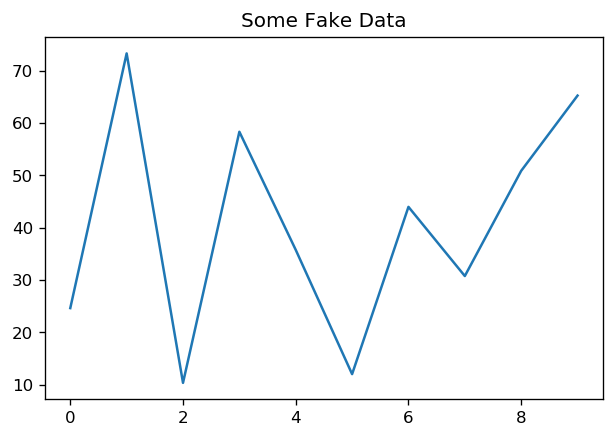

None


In [11]:
plt.figure(figsize: [6,4])
let fig = plt.plot(fakeData)
plt.title("Some Fake Data")
plt.show(fig);

#### A Deeper Dive into Swift 
Check out [this Google collab notebook](https://colab.research.google.com/github/tensorflow/swift/blob/master/docs/site/tutorials/a_swift_tour.ipynb) for a very useful and detailed overview of Swift syntax. It includes lots of exercises that you can use to practice and gauge your progress as you go!

## 0. Loading the MNIST Dataset

[Original course notebook](https://github.com/fastai/course-v3/blob/master/nbs/swift/00_load_data.ipynb)

As we implement all the components we'll use to train our XResNet model on the [Imagenette dataset](https://github.com/fastai/imagenette), such as batchnorm and cyclic learning rates, we'll want to be able to test each of these pieces as we go in order to ensure that they work the way we expect them to. Instead of performing sanity checks using the three-channel color images found in Imagenette, any debugging challenge that arises will be made much easier if we use the simple, one-channel images found in [MNIST](http://yann.lecun.com/exdb/mnist/).

We're thus going to create a function that can download and package the MNIST images into tensors that Swift for TensorFlow can use. Unsurprisingly, there will be a few building-blocks that we'll first need to make.

#### Executing shell commands from Swift for Jupyter
After we download MNIST, we'll need to unzip the dataset, so we need logic that lets us run any shell command from a notebook cell:

In [12]:
public extension String{
    @discardableResult
    func shell(_ args: String...) -> String {
        let task = Process()
        let pipe = Pipe()
        task.executableURL = URL(fileURLWithPath: self)
        task.arguments = args
        task.standardOutput = pipe
        
        do {
            try task.run()
        } catch {
            print("Unexpected error: \(error).")
        }
        
        let data = pipe.fileHandleForReading.readDataToEndOfFile()
        return String(data: data, encoding: String.Encoding.utf8) ?? ""
    }
}

Let's test it out by using the `ls` command to get a list all items in the current directory; we'll print out the name of the first item:

In [13]:
let dir_items = "/bin/ls".shell()
print(dir_items[..<dir_items.index(of: "\n")!])

00_exports-Copy1.ipynb


#### Downloading a file
Of course, we also need to perform the download that retrieves the MNIST dataset:

In [14]:
public func downloadFile(_ url: String, dest: String? = nil, force: Bool = false) {
    let dest_name = dest ?? (Path.cwd/url.split(separator: "/").last!).string
    let url_dest = URL(fileURLWithPath: (dest ?? (Path.cwd/url.split(separator: "/").last!).string))
    if !force && Path(dest_name)!.exists { return }
    
    print("Downloading \(url)...")
    
    if let content = Just.get(url).content {
        do {
            try content.write(to: URL(fileURLWithPath: dest_name))
        } catch {
            print("Can't write to \(url_dest).\n\(error)")
        }
    } else {
        print("Can't reach \(url)")
    }
}

Let's test it out by downloading the `.gz` file that contains the MNIST dataset's training images:

In [15]:
downloadFile("https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz")

Just to verify that the file did, indeed, download:

In [16]:
print("/bin/ls".shell("/home/ubuntu/fastai_docs/dev_course/dl2/train-images-idx3-ubyte.gz"))

/home/ubuntu/fastai_docs/dev_course/dl2/train-images-idx3-ubyte.gz



#### Converting MNIST data into a `Tensor`
Finally, we'll need to be able put the MNIST image data inside tensors. Our process will be to read-in the MNIST images in byte format and then immediately store them as `Uint8`. Then, we will convert the images themselves to the Swift `Float` data type, and the images' labels to the Swift `Int32` type. The goal is to ultimately have four tensors that contain:
1. Training images stored as Float.
2. Training labels stored as Int32.
3. Validation images stored as Float.
4. Validation labels stored as Int32.

However, note that by default, Swift for TensorFlow can only place certain data types inside a tensor. So in order to be able to create our tensors, we need to have a way of assuring Swift's compiler of the following:
1. The tensors will contain a data type that conforms to a data type that TensorFlow can handle, which for our case will be `TensorFlowScalar`.
2. That we are initially storing the data read as bytes under a format, `UInt8`, that is also compatible with `TensorFlowScalar`.
3. And finally, that the Swift data types that we want our tensors to ultimately contain (`Float` and `Int32`) are themselves compatible with `TensorFlowScalar`.

By creating a new protocol called `ConvertibleFromByte` that will conform to `TensorFlowScalar`, and that also will have an init function that expects `UInt8` inputs, we explicitly handle steps 1 and 2:

In [17]:
protocol ConvertibleFromByte: TensorFlowScalar {
    init(_ d: UInt8)
}

After this, step 3 can be satisfied by extending Swift's `Float` and `Int32` types so that they also conform to the `ConvertibleFromByte` protocol:

In [18]:
extension Float : ConvertibleFromByte {}
extension Int32 : ConvertibleFromByte {}

Thanks to this, when we specify that the function that creates our MNIST tensors should return `Tensor<Float>` and `Tensor<Int32>`, the compiler won't complain.

Here's a generic convenience method that can be used to convert some data to a Tensor of any Swift type that conforms to `ConvertibleFromByte`:

In [19]:
extension Data {
    func asTensor<T: ConvertibleFromByte>() -> Tensor<T> {
        return Tensor(map(T.init))
    }
}

#### `loadMNIST`
And here's the function that puts all the steps above together. It downloads, unzips, and converts the MNIST training and validation sets into images and labels tensors.

Why do we make it generic? Because we want to be able to use it to handle either Float or Int32 inputs, depending on whether we're packaging MNIST images into tensors, or packaging the labels into tensors.

In [20]:
func loadMNIST<T: ConvertibleFromByte>(training: Bool, labels: Bool,
                                       path: Path, flat: Bool) -> Tensor<T> {
    let split = training ? "train" : "t10k"
    let kind = labels ? "labels" : "images"
    let num_images = training ? 60000 : 10000
    let shape: TensorShape = labels ? [num_images] : (flat ? [num_images, 784] : [num_images, 28, 28])
    let dropK = labels ? 8 : 16
    let baseURL = "https://storage.googleapis.com/cvdf-datasets/mnist/"
    let fname = split + "-" + kind + "-idx\(labels ? 1 : 3)-ubyte"
    let file = path/fname
    if !file.exists {
        // Download MNIST dataset.
        downloadFile("\(baseURL)\(fname).gz", dest: (path/"\(fname).gz").string)
        // Unzip MNIST dataset.
        "/bin/gunzip".shell("-fq", (path/"\(fname).gz").string)
    }
    
    let data = try! Data(contentsOf: URL(fileURLWithPath: file.string)).dropFirst(dropK)
    if labels {
        return data.asTensor()
    } else {
        return data.asTensor().reshaped(to: shape)
    }
}

public func loadMNIST(path: Path, flat: Bool = false) -> (Tensor<Float>, Tensor<Int32>,
                                                          Tensor<Float>, Tensor<Int32>) {
    try! path.mkdir(.p)
    return (
        loadMNIST(training: true, labels: false, path: path, flat: flat) / 255.0,
        loadMNIST(training: true, labels: true, path: path, flat: flat),
        loadMNIST(training: false, labels: false, path: path, flat: flat) / 255.0,
        loadMNIST(training: false, labels: true, path: path, flat: flat)
        
    )
}

Let's test it out by loading the training and validation MNIST images/labels:

In [21]:
public let mnistPath = Path.home/".fastai"/"data"/"mnist_tst"

In [22]:
let (xTrain, yTrain, xValid, yValid) = loadMNIST(path: mnistPath)
xTrain.shape

▿ [60000, 28, 28]
  ▿ dimensions : 3 elements
    - 0 : 60000
    - 1 : 28
    - 2 : 28


A few more sanity checks to verify that our `loadMNIST` convenience function is actually able to get MNIST properly loaded:

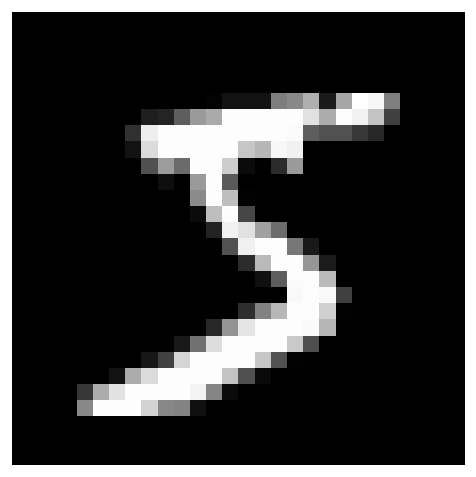

Image's training label: 5


In [23]:
let mnistImg = xTrain[0].makeNumpyArray()

plt.figure(figsize: [5,5])
plt.axis("off");
plt.show(plt.imshow(X: mnistImg, cmap: "gray"));

print("Image's training label: \(yTrain[0])")

## 1a. fastai Layers

[Original course notebook](https://github.com/fastai/course-v3/blob/master/nbs/swift/01a_fastai_layers.ipynb)

While the Swift for TensorFlow library has [its native implementations](https://github.com/tensorflow/swift-apis) of common neural network layers (e.g. fully-connected, convolutional, etc.), there is still one important capability that its default layer definitions lack: the ability to include callbacks. In order to use techniques like the one cycle policy when training our XResNet, we will need to be able to place delegate callbacks (identical in functionality to [PyTorch hooks](https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#forward-and-backward-function-hooks)) in our model's layers. Since Swift for TensorFlow uses a protocol to define its basic `Layer` type, it turns out that it's pretty straightforward to add in the callback support that we'll need.

#### Kaiming Init by Default
Before we do this, there are two odds and ends we want to also tie up. First off, we're going to ensure that each layer's weights tensor is always initialized with Kaiming init by default:

In [24]:
public extension Tensor where Scalar: TensorFlowFloatingPoint {
    // Assumes ReLU activations will be used.
    // Uses fan-in method for kaiming init.
    init(kaimingNormal shape: TensorShape, a: Double = 0.0) {
        let gain = Scalar.init(TensorFlow.sqrt(2.0 / (1.0 + TensorFlow.pow(a, 2))))
        
        // Calculate fan-in (number of incoming connections to the layer):
        let spatialDimCount = shape.count - 2
        let receptiveField = shape[0..<spatialDimCount].contiguousSize
        let fanIn = shape[spatialDimCount] * receptiveField
        
        // Initialize weights tensor using Kaiming:
        self.init(randomNormal: shape)
        self *= Tensor<Scalar>(gain / TensorFlow.sqrt(Scalar(fanIn)))
    }
}

For reference, you can compare the above implementation with the [PyTorch version](https://pytorch.org/docs/stable/_modules/torch/nn/init.html) of Kaiming init. 

#### `std` function
Swift for TensorFlow currently uses "standardDeviation," instead of the more simple "std," as the name of its standard deviation function. 

So for the sake of convenience, and since this is how its done in Numpy, PyTorch and seemingly everywhere, we'll make it possible for us to get by with using just `std()`:

In [25]:
public extension Tensor where Scalar: TensorFlowFloatingPoint {
    func std() -> Tensor<Scalar> { return standardDeviation() }
    func std(alongAxes a: [Int]) -> Tensor<Scalar> { return standardDeviation(alongAxes: a) }
    func std(alongAxes a: Tensor<Int32>) -> Tensor<Scalar> { return standardDeviation(alongAxes: a) }
    func std(alongAxes a: Int...) -> Tensor<Scalar> { return standardDeviation(alongAxes: a) }
    func std(squeezingAxes a: [Int]) -> Tensor<Scalar> { return standardDeviation(squeezingAxes: a) }
    func std(squeezingAxes a: Tensor<Int32>) -> Tensor<Scalar> { return standardDeviation(squeezingAxes: a) }
    func std(squeezingAxes a: Int...) -> Tensor<Scalar> { return standardDeviation(squeezingAxes: a) }
}

#### Deep-dive into Swift Protocols
Similar to what PyTorch does with its [`nn.Module` class](https://pytorch.org/docs/stable/nn.html?highlight=module#torch.nn.Module), Swift for TensorFlow offers a protocol called `Layer` that defines the basic behavior of all neural network model layers. 

Now, before we dive into exactly how the Swift `Layer` protocol works, you might be wondering something like:: 

>"If Swift offers programmers the ability to create classes, just like PyTorch does, what on earth are Swift protocols and why does Swift for TensorFlow use one instead of a Swift class to define `Layer`?

Well, while Swift does include support for classes, which are still used when state needs to be stored and saved (i.e. when we want to store a variable as a reference type), the intention of Swift's creators is that when functionality or properties need to be inherited or extended, that Swift developers will gravitate toward using a *protocol-oriented* programming style.

[Here](https://docs.google.com/presentation/d/1dc6o2o-uYGnJeCeyvgsgyk05dBMneArxdICW5vF75oU/edit#slide=id.g5674d3ead7_0_474) is some of what Swift creator Chris Lattner says about Swift protocols:
* Protocols define a common interface to implementations.
* This makes them like interfaces or abstract classes seen in languages like Java.
* Protocols' main job is to categorize and describe groups of types. And protocols do this by way of defining minute details or high-level behaviors that can apply to such groups. For example, the following protocol ensures that the `==` operator can be used to verify whether two variables of any type that conforms to the protocol are indeed equal:
```swift
protocol Equatable {
    static func == (lhs: Self, rhs: Self) -> Bool
}
```
* Parent-protocols can be inherited by other protocols, just like classes and sub-classes in Python.
* Protocols make it easy to specify capabilities of generic types. For example, in the following function, we allow it to accept inputs of any type, so long as they conform to the `Equatable` protocol:
```swift
static func != <T: Equatable>(lhs: T, rhs: T) -> Bool {
    return !(lhs == rhs)
}
```
* Protocols can easily be extended. And when this happens, all types already conforming to the protocol immediately and automatically can take advantage of new properties that have been added to the now-extended protocol. For example, we can add an attribute indicating whether or not a number is odd to all types that conform to the `BinaryInteger` protocol:
```swift
extension BinaryInteger {
    var isOdd : Bool { return self & 1 != 0 }
}
```
* We can define extensions to protocols and constrain them so that they only apply in situations we desire. For example, if we have a protcol `Countable` with a `count` property that returns the total number of elements, we can write an extension that will apply to any sequence made up of elements that conform to `Countable` that returns the `totalCount`, or the total sum of the `count` of all `Countable` elements:

```swift
protocol Countable {
    var count: Int { get }
}
extension Array: Countable {}

extension Sequence where Element: Countable {
    var totalCount: Int { return map{ $0.count }.reduce(0, +) }
}

var arrayOfArrays = [[1,2,3], [4,5], [1]]
print(arrayOfArrays.count)  // 3
arrayOfArrays.totalCount    // 6
```
* Protocols aren't just about offering access to functions, but are also all about determining what kinds of types can get what kinds of behavior from which functions. You can think of protocols serving as "air traffic controllers" to both expand and or limit what various types can do. Note that to make this possible, types don't auto-conform in Swift. To illustrate why and how this works, say for example that we have a `Shape` protocol that offers a `draw()` function to all types that conform to `Shape`. Now suppose also that we extend `Shape` to offer a `refresh()` function that clears the screen before drawing a particular shape. If Swift types auto-conformed, then any type that's *not* a `Shape`, but *did* implement a `draw()` method would also `refresh()` the screen each time it appears, which is not something we would likely intend to have happen. 

```swift
protocol Shape {
    func draw()
}

extension Shape {
    func refresh() {
        clearCanvas()
        draw()
    }
}

struct 🛑 : Shape {
    func draw() { ... }
}

struct ♦️ : Shape {
    func draw() { ... }
}

// The 🤠type is not a Shape. So it doesn't have a refresh() method.
struct 🤠 : {
    func draw() { ... }
}
```

If you'd like to go further, feel free to take a look at [this talk](https://www.youtube.com/watch?v=g2LwFZatfTI) on protocol-oriented programming, given at Apple's WWDC 2015 conference.

#### Deep-dive into Swift for TensorFlow's `Layer` Protocol
Since, as mentioned earlier, we want to eventually extend the default `Layer` protocol that's native to Swift for TensorFlow, let's first take a look at it and see what it can already do.
```swift
protocol Layer: Differentiable {
    ...
}
```
The above line declares the `Layer` protocol, and specifies that all `Layer` types will also conform to the Swift for TensorFlow [`Differentiable` protocol](https://github.com/apple/swift/blob/tensorflow/stdlib/public/core/AutoDiff.swift#L154). 
```swift
@differentiable
func call(_ input: Input) -> Output
```
And the above logic dictates that any `Layer` type must contain a `call` method, and that this method must always be `differentiable`.
```swift
associatedtype Input: Differentiable
associatedtype Output: Differentiable
```
Finally, these two lines require that any `Layer` type needs to have both `Input` and `Output` types, and that they both must also be `differentiable`.

#### `FALayer`
Now we're ready to extend Swift for TensorFlow's `Layer` protocol so that callbacks can be installed in all `Layer` types. These callbacks will allow us to train our XResNet model in precisely the way we want.

`FALayer` is just like `Layer` except that it can store `delegates`. Any type (any other kinds of layers we may define) that conform to `FALayer` will have to implement a method called `forward()` instead of `call`:

In [26]:
public protocol FALayer: Layer {
    var delegates: [(Output) -> ()] { get set }
    
    // All layers that conform to FALayer will implement this
    // method instead of call().
    @differentiable
    func forward(_ input: Input) -> Output
    
    associatedtype Input
    associatedtype Output
}

But we're not quite done yet. Swift for TensorFlow doesn't yet know exactly what it's supposed to do with `forward`.

To solve this, and to save a lot of boilerplate code that we'd otherwise have to include in the definition of every future layer type that will conform to `FALayer`, we can write an extension to `FALayer` that "calls" `FALayer`'s `forward` method. The logic in the `callAsFunction` function below will tell Swift for TensorFlow to handle `forward` in the way it would typically handle `call`. 

Additionally, in the same extension we also add logic that invokes any delegates that may be present:

In [27]:
public extension FALayer {
    
    // There is a linker error if we use '@differentiating', so 
    // '@differentiable' is used instead. 
    // Bug is at: https://bugs.swift.org/browse/TF-476
    @differentiable(vjp: callGrad)
    func callAsFunction(_ input: Input) -> Output {
        let activation = forward(input)
        for d in delegates { d(activation) }
        return activation
    }
    
    // S4TF autodiff currently synthesizes a leaking VJP here so we 
    // need to define our own VJP. 
    // Bug is at: https://bugs.swift.org/browse/TF-475
    func callGrad(_ input: Input) ->
    (Output, (Self.Output.TangentVector) -> (Self.TangentVector, Self.Input.TangentVector)) {
        return Swift.valueWithPullback(at: self, input) { (m, i) in m.forward(i) }
    }
    
    // Also create a convenience method to add a delegate to any layer.
    mutating func addDelegate(_ d: @escaping (Output) -> ()) { delegates.append(d) }
}

Now that we've got a basic layer implementation that supports callbacks, we build on top of this define all the other kinds of layers (dense, conv, and avgerage pooling) that we'll need.

#### Dense Layer

In [28]:
@frozen
public struct FADense<Scalar: TensorFlowFloatingPoint>: FALayer {
    // Following two typealiases can be removed after 
    // https://bugs.swift.org/browse/TF-603 is done.
    public typealias Input = Tensor<Scalar>
    public typealias Output = Tensor<Scalar>
    
    public var weight: Tensor<Scalar>
    public var bias: Tensor<Scalar>
    public typealias Activation = @differentiable (Tensor<Scalar>) -> Tensor<Scalar>
    @noDerivative public var delegates: [(Output) -> ()] = []
    @noDerivative public let activation: Activation
    
    public init(weight: Tensor<Scalar>, bias: Tensor<Scalar>, activation: @escaping Activation) {
        self.weight = weight
        self.bias = bias
        self.activation = activation
    }
    
    @differentiable
    public func forward (_ input: Tensor<Scalar>) -> Tensor<Scalar> {
        return activation(input • weight + bias)
    }
}

// A convenience init.
public extension FADense {
    init(_ nIn: Int, _ nOut: Int, activation: @escaping Activation = identity) {
        self.init(weight: Tensor(kaimingNormal: [nIn, nOut]), bias: Tensor(zeros: [nOut]),
                  activation: activation)
    }
}

#### Conv2D Layer (with no bias)

In [29]:
@frozen
public struct FANoBiasConv2D<Scalar: TensorFlowFloatingPoint>: FALayer {
    public typealias Input = Tensor<Scalar>
    public typealias Output = Tensor<Scalar>
    public var filter: Tensor<Scalar>
    public typealias Activation = @differentiable (Tensor<Scalar>) -> Tensor<Scalar>
    @noDerivative public let activation: Activation
    @noDerivative public let strides: (Int, Int)
    @noDerivative public let padding: Padding
    @noDerivative public var delegates: [(Output) -> ()] = []
    
    public init(filter: Tensor<Scalar>, activation: @escaping Activation, 
                strides: (Int, Int), padding: Padding) {
        self.filter = filter
        self.activation = activation
        self.strides = strides
        self.padding = padding
    }
    
    @differentiable 
    public func forward(_ input: Tensor<Scalar>) -> Tensor<Scalar> {
        return activation(conv2D(input, filter: filter, strides: (1, strides.0, strides.1, 1),
                                 padding: padding))
    }
}

public extension FANoBiasConv2D {
    init(filterShape: (Int, Int, Int, Int), strides: (Int, Int) = (1, 1),
         padding: Padding = .same, activation: @escaping Activation = identity) {
        let filterTensorShape = TensorShape([filterShape.0, filterShape.1, filterShape.2, filterShape.3])
        self.init(filter: Tensor(kaimingNormal: filterTensorShape), activation: activation,
                  strides: strides, padding: padding)
    }
}

public extension FANoBiasConv2D {
    init(_ cIn: Int, _ cOut: Int, ks: Int, stride: Int = 1, padding: Padding = .same,
         activation: @escaping Activation = identity) {
        self.init(filterShape: (ks, ks, cIn, cOut), strides: (stride, stride), 
                  padding: padding, activation: activation)
    }
}

#### Conv2D Layer (with bias)

In [30]:
@frozen
public struct FAConv2D<Scalar: TensorFlowFloatingPoint>: FALayer {
    public typealias Input = Tensor<Scalar>
    public typealias Output = Tensor<Scalar>
    public var filter: Tensor<Scalar>
    public var bias: Tensor<Scalar>
    public typealias Activation = @differentiable (Tensor<Scalar>) -> Tensor<Scalar>
    @noDerivative public let activation: Activation
    @noDerivative public let strides: (Int, Int)
    @noDerivative public let padding: Padding
    @noDerivative public var delegates: [(Output) -> ()] = []
    
    public init(filter: Tensor<Scalar>, bias: Tensor<Scalar>, activation: @escaping Activation, 
                strides: (Int, Int), padding: Padding) {
        self.filter = filter
        self.bias = bias
        self.activation = activation
        self.strides = strides
        self.padding = padding
    }
    
    @differentiable 
    public func forward(_ input: Tensor<Scalar>) -> Tensor<Scalar> {
        return activation(conv2D(input, filter: filter, strides: (1, strides.0, strides.1, 1),
                                 padding: padding) + bias)
    }
}

public extension FAConv2D {
    init(filterShape: (Int, Int, Int, Int), strides: (Int, Int) = (1, 1),
         padding: Padding = .same, activation: @escaping Activation = identity) {
        let filterTensorShape = TensorShape([filterShape.0, filterShape.1, filterShape.2, filterShape.3])
        self.init(filter: Tensor(kaimingNormal: filterTensorShape), bias: Tensor(zeros: TensorShape([filterShape.3])),
                  activation: activation, strides: strides, padding: padding)
    }
}

public extension FAConv2D {
    init(_ cIn: Int, _ cOut: Int, ks: Int, stride: Int = 1, padding: Padding = .same,
         activation: @escaping Activation = identity) {
        self.init(filterShape: (ks, ks, cIn, cOut), strides: (stride, stride), 
                  padding: padding, activation: activation)
    }
}

#### AvgPool2D Layer

In [31]:
@frozen
public struct FAAvgPool2D<Scalar: TensorFlowFloatingPoint>: FALayer {
    public typealias Input = Tensor<Scalar>
    public typealias Output = Tensor<Scalar>
    
    @noDerivative let poolSize: (Int, Int, Int, Int)
    @noDerivative let strides: (Int, Int, Int, Int)
    @noDerivative let padding: Padding
    @noDerivative public var delegates: [(Output) -> ()] = []
    
    public init(poolSize: (Int, Int, Int, Int), strides: (Int, Int, Int, Int), padding: Padding) {
        self.poolSize = poolSize
        self.strides = strides
        self.padding = padding
    }
    
    @differentiable
    public func forward(_ input: Tensor<Scalar>) -> Tensor<Scalar> {
        return avgPool2D(input, filterSize: poolSize, strides: strides, padding: padding)
    }
}

public extension FAAvgPool2D {
    init(poolSize: (Int, Int), strides: (Int, Int), padding: Padding = .valid) {
        self.init(poolSize: (1, poolSize.0, poolSize.1, 1), strides: (1, strides.0, strides.1, 1),
                  padding: padding)
    }
}

public extension FAAvgPool2D {
    init(_ size: Int, padding: Padding = .valid) {
        self.init(poolSize: (1, size, size, 1), strides: (1, size, size, 1),
                  padding: padding)
    }
}

#### GlobalAvgPool2D Layer

In [32]:
@frozen
public struct FAGlobalAvgPool2D<Scalar: TensorFlowFloatingPoint>: FALayer {
    public typealias Input = Tensor<Scalar>
    public typealias Output = Tensor<Scalar>
    @noDerivative public var delegates: [(Output) -> ()] = []
    
    public init() {}
    
    @differentiable
    public func forward(_ input: Tensor<Scalar>) -> Tensor<Scalar> {
        return input.mean(squeezingAxes: [1,2])
    }
}

We've implemented all the `FALayer` types that we'll need to build our model, and there are now a few more housekeeping items to attend to. We should implement a bunch of conveniences that'll make the rest of the work ahead easier.

#### Make the `Array` type  differentiable
First off, so that we can use arrays to house our model's layers inside layer groups, we need to ensure that the Swift array type, itself, is differentiable.

In [33]:
extension Array: Layer where Element: Layer, Element.Input == Element.Output {
    public typealias Input = Element.Input
    public typealias Output = Element.Output
    
    @differentiable(vjp: _vjpApplied)
    public func callAsFunction(_ input: Input) -> Output {
        var activation = input
        for layer in self {
            activation = layer(activation)
        }
        return activation
    }
    
    public func _vjpApplied(_ input: Input) -> 
    (Output, (Output.TangentVector) -> (Array.TangentVector, Input.TangentVector)) {
        var activation = input
        var pullbacks : [(Input.TangentVector) -> (Element.TangentVector, Input.TangentVector)] = []
        for layer in self {
            let (newActivation, newPullback) = layer.valueWithPullback(at: activation) { $0($1) }
            activation = newActivation
            pullbacks.append(newPullback)
        }
        
        func pullback(_ v: Input.TangentVector) -> (Array.TangentVector, Input.TangentVector) {
            var activationGradient = v
            var layerGradients: [Element.TangentVector] = []
            for pullback in pullbacks.reversed() {
                let (newLayerGradient, newActivationGradient) = pullback(activationGradient)
                activationGradient = newActivationGradient
                layerGradients.append(newLayerGradient)
            }
            return (Array.TangentVector(layerGradients.reversed()), activationGradient)
        }
        
        return (activation, pullback)
    }
}

#### Simplifying our nomenclature for keypaths and differentiable variables
We can also add in some shorthand that allows us to refer to `recursivelyAllWritableKeyPaths` as just `keyPaths` and `allDifferentiableVariables` as just `variables`.

Note that further on down [below](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/13_swift_resnet_pipeline_s4tf_v04_my_reimplementation.ipynb#Swift-keyPaths) we'll spend some time on how Swift keypaths work and why we use them.

In [34]:
extension KeyPathIterable {
    public var keyPaths: [WritableKeyPath<Self, Tensor<Float>>] {
        return recursivelyAllWritableKeyPaths(to: Tensor<Float>.self)
    }
}

extension Layer {
    public var variables: AllDifferentiableVariables {
        get { return allDifferentiableVariables }
        set { allDifferentiableVariables = newValue }
    }
}

#### Compose anywhere from 2 to 6 layers
We also extend the `Differentiable` protocol to provide an overloaded `compose` method that can connect together anywehre from two to up to six model layers:

In [35]:
public extension Differentiable {
    
    @differentiable
    func compose<L1: Layer, L2: Layer>(_ l1: L1, _ l2: L2) -> L2.Output
    where L1.Input == Self, L1.Output == L2.Input {
        return sequenced(through: l1, l2)          
    }
    
    @differentiable
    func compose<L1: Layer, L2: Layer, L3: Layer>(_ l1: L1, _ l2: L2, _ l3: L3) -> L3.Output
    where L1.Input == Self, L1.Output == L2.Input, L2.Output == L3.Input {
        return sequenced(through: l1, l2, l3)          
    }
    
    @differentiable
    func compose<L1: Layer, L2: Layer, L3: Layer, L4: Layer>(_ l1: L1, _ l2: L2, _ l3: L3, 
        _ l4: L4) -> L4.Output
    where L1.Input == Self, L1.Output == L2.Input, L2.Output == L3.Input, L3.Output == L4.Input {
        return sequenced(through: l1, l2, l3, l4)          
    }
    
    @differentiable
    func compose<L1: Layer, L2: Layer, L3: Layer, L4: Layer, L5: Layer>(_ l1: L1, _ l2: L2, _ l3: L3, 
        _ l4: L4, _ l5: L5) -> L5.Output
    where L1.Input == Self, L1.Output == L2.Input, L2.Output == L3.Input, L3.Output == L4.Input,
          L4.Output == L5.Input {
        return sequenced(through: l1, l2, l3, l4, l5)          
    }
    
    @differentiable
    func compose<L1: Layer, L2: Layer, L3: Layer, L4: Layer, L5: Layer, L6: Layer>(_ l1: L1, 
        _ l2: L2, _ l3: L3, _ l4: L4, _ l5: L5, _ l6: L6) -> L6.Output
    where L1.Input == Self, L1.Output == L2.Input, L2.Output == L3.Input, L3.Output == L4.Input,
          L4.Output == L5.Input, L5.Output == L6.Input {
        return sequenced(through: l1, l2, l3, l4, l5, l6)          
    }
}

#### A convenient shorthand for representing Float Tensors¶

In [36]:
public typealias TF = Tensor<Float>

#### A convenient shorthand for representing Int32 Tensors

In [37]:
public typealias TI = Tensor<Int32>

## 3. Loss functions and mini-batch training

[Original course notebook](https://github.com/fastai/course-v3/blob/master/nbs/swift/03_minibatch_training.ipynb)

#### Calculating loss
Our model will use a categorical cross-entropy loss function. If we were to implement this from scratch, we'd first need to write a log-softmax function that converts our model's final layer output into a vector of (log) softmax probabilities. Then we'd have to write a negative log-likelihood function that computes the difference, or loss, between our model's log-softmax probabilities and the actual ground truth label.

We've [already implemented](https://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/03_minibatch_training_my_reimplementation.ipynb?flush_cache=true) these three functions in PyTorch, but we'll do it once more here in Swift so we can continue to get a feel for how Swift syntax works. Note that we'll also use the [log-sum-exp trick](https://en.wikipedia.org/wiki/LogSumExp) here to compute our log softmax. Log-sum-exp helps us compute the sum of exponentials in a more stable manner.

In [38]:
func logSumExp<Scalar>(_ x: Tensor<Scalar>) -> Tensor<Scalar>
where Scalar: TensorFlowFloatingPoint {
    let m = x.max(alongAxes: -1)
    return m + log(exp(x-m).sum(alongAxes: -1))
}

In [39]:
func logSoftmax<Scalar>(_ activations: Tensor<Scalar>) -> Tensor<Scalar>
where Scalar: TensorFlowFloatingPoint {
    return activations - logSumExp(activations)
}

In [40]:
func nll<Scalar>(_ input: Tensor<Scalar>, _ target: TI) -> Tensor<Scalar>
where Scalar: TensorFlowFloatingPoint {
    let idx: TI = Raw.range(start: Tensor(0), limit: Tensor(numericCast(target.shape[0])),
                            delta: Tensor(1))
    let indices = Raw.concat(concatDim: Tensor(1), [idx.expandingShape(at: 1),
                                                   target.expandingShape(at: 1)])
    let losses = Raw.gatherNd(params: input, indices: indices)
    return -losses.mean()
}

Similar to PyTorch, Swift for TensorFlow combines `nll` loss and softmax together in one native function called `softmaxCrossEntropy`. We'll use this built-in implementation for the rest of this notebook.

#### Accuracy metric

In [41]:
public func accuracy(_ output: TF, _ target: TI) -> TF {
    let corrects = TF(output.argmax(squeezingAxis: 1) .== target)
    return corrects.mean()
}

#### Training a simple fully-connected model
We've implemented a lot of stuff so far, so we should make sure that at least some of it works. Let's train a simple fully-connected model using MNIST images flattened into 1-d vectors as training inputs. 

In [42]:
var (xTrain, yTrain, xValid, yValid) = loadMNIST(path: mnistPath, flat: true)
xTrain.shape

▿ [60000, 784]
  ▿ dimensions : 2 elements
    - 0 : 60000
    - 1 : 784


In [43]:
let trainMean = xTrain.mean()
let trainStd = xTrain.std()

In [44]:
public func normalize(_ x: TF, mean: TF, std: TF) -> TF {
    return (x - mean) / std
}

In [45]:
xTrain = normalize(xTrain, mean: trainMean, std: trainStd)
xValid = normalize(xValid, mean: trainMean, std: trainStd)

In [46]:
let (n, m) = (xTrain.shape[0], xTrain.shape[1])
let c = yTrain.max().scalarized() + 1
print(n, m, c)

60000 784 10


In [47]:
let nHid = 50

public struct SimpleModel: Layer {
    public var layer1: FADense<Float>
    public var layer2: FADense<Float>
    
    public init(nIn: Int, nHid: Int, nOut: Int){
        layer1 = FADense(nIn, nHid, activation: relu)
        layer2 = FADense(nHid, nOut)
    }
    
    @differentiable
    public func callAsFunction(_ input: TF) -> TF {
        return input.sequenced(through: layer1, layer2)
    }
}

In [48]:
var model = SimpleModel(nIn: m, nHid: nHid, nOut: Int(c))

var bs = 64
var lr: Float = 0.4
var epochs = 1

We'll soon write a much more robust training loop that includes callbacks. But right now, let's start off with a simple loop that specifies all layers' weight and bias update steps, one by one:

In [49]:
for epoch in 1 ... epochs {
    for i in 0 ..< (n-1)/bs {
        let startIdx = i * bs
        let endIdx = startIdx + bs
        let xb = xTrain[startIdx..<endIdx]
        let yb = yTrain[startIdx..<endIdx]
        
        let (loss, grads) = model.valueWithGradient {
            softmaxCrossEntropy(logits: $0(xb), labels: yb)
        }
        
        model.layer1.weight -= lr * grads.layer1.weight
        model.layer1.bias   -= lr * grads.layer1.bias
        model.layer2.weight -= lr * grads.layer2.weight
        model.layer2.bias   -= lr * grads.layer2.bias
    }
}

In [50]:
var preds = model(xValid)
accuracy(preds, yValid)

0.9298


An accuray score near `90%` after one epoch of training should be encouraging. This tells us that we've likely done a good job implementing the extension to Swift's `Layer` struct (`FALayer`), as well as our custom version of a fully connected layer (`FADense`). It also shows us we have a solid basic understanding of how a training loop works.

We'll now begin a process of steadily improving our training loop until we get to the point where it's as flexible (can support callbacks) as we'll need.

#### Refactoring the training loop for mini-batch training
So let's refactor the above training loop, this time using Swift for TensorFlow's `Dataset` class to automatically manage batching during training. Conveniently, this class is able to shuffle our training inputs each epoch.

This time when we train, we'll also include Swift for TensorFlow's native SGD as our optimizer.

In [51]:
public struct DataBatch<Inputs: Differentiable & TensorGroup, Labels: TensorGroup>: TensorGroup {
    public var xb: Inputs
    public var yb: Labels
    
    public init(xb: Inputs, yb: Labels) {
        self.xb = xb
        self.yb = yb
    }
}

In [52]:
let trainDS = Dataset(elements: DataBatch(xb: xTrain, yb: yTrain)).batched(bs)

In [53]:
model = SimpleModel(nIn: m, nHid: nHid, nOut: Int(c))
var optimizer = SGD(for: model, learningRate: lr)

In [54]:
for epoch in 1...epochs {
    for batch in trainDS.shuffled(sampleCount: yTrain.shape[0], randomSeed: 42) {
        let (loss, grads) = model.valueWithGradient {
            softmaxCrossEntropy(logits: $0(batch.xb), labels: batch.yb)
        }
        optimizer.update(&model.variables, along: grads)
    }
}

In [55]:
preds = model(xValid)
accuracy(preds, yValid)

0.9457


#### Refactoring into a generic training loop
Let's move away from simple for-loops and refactor our training logic once more into a more generalized functional called `train`. We'll use generic types to represent the Optimizer and Labels, and this architecture will get us closer to understanding what it's like to have a training loop that can handle any kind of optimizer, dataset, loss function, and model that we throw at it.

In [56]:
public func train<Opt: Optimizer, Label: TensorGroup>(_ model: inout Opt.Model, 
                                                      on ds: Dataset<DataBatch<Opt.Model.Input, Label>>,
                                                      using opt: inout Opt, 
                                                      lossFunc: @escaping @differentiable (Opt.Model.Output, @nondiff Label) -> Tensor<Opt.Scalar>)
where Opt.Model: Layer, Opt.Model.Input: TensorGroup, 
Opt.Model.TangentVector == Opt.Model.AllDifferentiableVariables, Opt.Scalar: TensorFlowFloatingPoint {
    
    for batch in ds {
        let (loss, 𝛁model) = model.valueWithGradient {
            lossFunc($0(batch.xb), batch.yb)
        }
        opt.update(&model.variables, along: 𝛁model)
    } 
}

In [57]:
model = SimpleModel(nIn: m, nHid: nHid, nOut: Int(c))
optimizer = SGD(for: model, learningRate: lr)

In [58]:
train(&model, on: trainDS, using: &optimizer, lossFunc: softmaxCrossEntropy)

In [59]:
preds = model(xValid)
accuracy(preds, yValid)

0.9147


So far so good! The next big step will be to implement the final version of our training loop that supports the callbacks that'll allow us to train models using hyper parameter scheduling and other goodies!

## 4. Datasets, and the Training Loop and its Callbacks

[Original course notebook](https://github.com/fastai/course-v3/blob/master/nbs/swift/04_callbacks.ipynb)

#### Adding a wrapper to Swift for TensorFlow's default `Dataset` struct
First, however, there are three extra things we'll need, which the native `Dataset` struct of Swift for TensorFlow omits by default:
1. A `count` property so that we can know the length of the dataset, in order to perform hyperparameter scheduling.
2. Make it possible to save the original non-batched dataset under the variable `innerDS`. We want to be able to change batch size after creating a `Dataset`.
3. We need to be able to generate a fresh shuffling of the dataset every time we call `shuffle`, so we'll ensure that this happens inside the `ds` property.

In [60]:
public struct FADataset<Element> where Element: TensorGroup {
    public var innerDS: Dataset<Element>
    public var shuffle = false
    public var bs = 64
    public var dsCount: Int
    
    public var count: Int {
        return dsCount % bs == 0 ? dsCount / bs : dsCount / bs + 1
    }
    
    public var ds: Dataset<Element> {
        if !shuffle { return innerDS.batched(bs) }
        let seed = Int64.random(in: Int64.min..<Int64.max)
        return innerDS.shuffled(sampleCount: dsCount, randomSeed: seed).batched(bs)
    }
    
    public init(_ ds: Dataset<Element>, len: Int, shuffle: Bool = false, bs: Int = 64) {
        self.innerDS = ds
        self.dsCount = len
        self.shuffle = shuffle
        self.bs = bs
    }
}

The `DataBunch` struct will be responsible for grouping both the training and validation datasets together into one manageable unit:

In [61]:
public struct DataBunch<Element> where Element: TensorGroup {
    public var train, valid: FADataset<Element>
    
    public init(train: Dataset<Element>, valid: Dataset<Element>, 
                trainLen: Int, validLen: Int, bs: Int = 64) {
        self.train = FADataset(train, len: trainLen, shuffle: true, bs: bs)
        self.valid = FADataset(valid, len: validLen, shuffle: false, bs: 2 * bs)
    }
}

Let's make sure we can now use data bunches to get an accurate count of the number of items in one batch of the MNIST training set:

In [62]:
public func mnistDataBunch(path: Path = mnistPath, flat: Bool = false, bs: Int = 64) 
    -> DataBunch<DataBatch<TF, TI>> {
    let(xTrain, yTrain, xValid, yValid) = loadMNIST(path: path, flat: flat)
    return DataBunch(train: Dataset(elements: DataBatch(xb: xTrain, yb: yTrain)),
                     valid: Dataset(elements: DataBatch(xb: xValid, yb: yValid)),
                     trainLen: xTrain.shape[0],
                     validLen: xValid.shape[0],
                     bs: bs)
}

In [63]:
var mnistData = mnistDataBunch()
mnistData.train.count

938


In [64]:
// 60000 images in MNIST training set; if batchsize is 64, 
// expected total number of images in all but final batch 
// is 938 images per batch:
60000/64.0

937.5


Let's also make sure our MNIST data bunch shuffles its batches. i.e. the contents of each batch should vary from epoch to epoch. To test it out, we'll get our data bunch to return us two different versions of the first batch. If images' labels are getting shuffled, the contents of the two versions of the first batch ought to be different:

In [65]:
// Handy extension that'll make it possible for us to 
// easily get the first batch from our MNIST data bunch.
public extension Sequence {
    func first() -> Element? {
        return first(where: {_ in true} )
    }
}

In [66]:
mnistData.train.ds.first()!.yb

[4, 5, 5, 9, 9, 5, 6, 1, 1, 9, 7, 0, 9, 2, 8, 3, 3, 8, 7, 1, 7, 2, 1, 6, 6, 9, 9, 6, 1, 6, 1, 8, 4, 8, 3, 0, 3, 8, 2, 0, 8, 2, 2, 7, 5, 8, 1, 6, 6, 6, 0, 7, 6, 2, 5, 5, 7, 8, 1, 1, 8, 9, 3, 9]


In [67]:
mnistData.train.ds.first()!.yb

[4, 4, 5, 7, 4, 3, 7, 7, 1, 4, 3, 3, 7, 7, 6, 3, 8, 7, 2, 8, 3, 7, 0, 1, 0, 2, 9, 7, 3, 6, 1, 8, 1, 1, 4, 9, 1, 8, 8, 2, 1, 7, 2, 2, 5, 8, 2, 6, 0, 2, 4, 9, 8, 3, 6, 5, 0, 1, 0, 0, 0, 8, 3, 1]


There we go! Each time we grab the first batch from our MNIST data bunch, we have a different set of labels. This is strong evidence that our `FADataset` wrapper will be able to shuffle the contents of every batch, from epoch to epoch.

#### The `Learner` class that manages our training loop

And now the moment we've been waiting for! We're ready to implement a complete, robust training loop manager that supports delegates (callbacks). 

In order to have a callback enforce behavior (such as adjusting certain hyperparameter values) at a particular stage in the training loop, the practitioner can create a delegate object that implements at least one of the following functions found inside the `Learner` class. Each of these functions corresponds to a particular phase of the training cycle, such as the beginning of an individual batch, or the start of a brand new epoch:

```swift
open func trainingWillStart(learner: Learner) throws {}
open func trainingDidFinish(learner: Learner) throws {}
open func trainInferenceDidFinish(learner: Learner) throws {}
open func epochWillStart(learner: Learner) throws {}
open func epochDidFinish(learner: Learner) throws {}
open func validationWillStart(learner: Learner) throws {}
open func batchWillStart(learner: Learner) throws {}
open func batchDidFinish(learner: Learner) throws {}
open func didProduceNewGradient(learner: Learner) throws {}
open func optimizerDidUpdate(learner: Learner) throws {}
open func batchSkipped(learner: Learner, reason: String) throws {}
open func epochSkipped(learner: Learner, reason: String) throws {}
open func trainingStopped(learner: Learner, reason: String) throws {}
```

To summarize very succintly, the job of the `Learner` class is to initialize a model and train it on a dataset.

Now, one final question you might be asking yourself: "I thought Swift for TensorFlow was all about using structs and not classes. Isn't this because (as we learned [above](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/13_swift_resnet_pipeline_s4tf_v04_my_reimplementation.ipynb#Value-types-vs.-reference-types)), that structs are value types, which store their memory in the stack (not heap) and are therefore way more performant than classes, which are reference types and use the heap?"

It's a legitimate question, and one I asked myself. During his tutorial in the final fast.ai 2019 part II lecture, Chris Lattner [mentioned](https://docs.google.com/presentation/d/1dc6o2o-uYGnJeCeyvgsgyk05dBMneArxdICW5vF75oU/edit#slide=id.g5674d3ead7_0_12) that when the *identity* of a piece of information is important, classes should be used. It turns out that when Swift delegates are involved, identity most assuredly does matter. When a delegate makes a request, Swift always needs to know "who is asking." In other words, in order to be able to carry out whatever action the delegate is imploring the program to carry out, Swift needs to be able to know *who* (what object) the delegate belongs to. And why does Swift need to know this? Cause Swift needs to know which object is supposed to *carry out* the specific action that the delegate is requesting. The Swift compiler will then go tap that object on the back and ask it, "execuse me, can you please do (fill in the blank) for me?"

If `Learner` were a struct and not a class, there wouldn't be one canonical memory reference to an individual Learner (the manager of a particular training loop). Instead, since Learner would be a value type in this scenario, it's possible that there could be multiple copies of what we otherwise would intend to be one individual Learner. If a delegate does something like, say, request an early cancellation of training, which copy of the Learner should execute that command? Even worse, could we get into a situation where we have different copies of the same Learner training identical versions of our model simultaneously (and quite redundantly)?

Preventing all of the above snafus from happening is why the `Learner` class that manages our training loop is a class and not a struct. All the delegates we will create below, that will do things like schedule hyperparameters or stop training early, will need to have one, singular, canonical `Learner()` object that has the responsibility of executing all commands that they give.

If you want to dive deeper into structs vs. classes where delegates are concerned, please visit the [wonderful Medium post](https://medium.com/tech-travelstart/could-struct-be-a-delegate-in-swift-fd86f5adbe16) by [Yuta Lin](https://medium.com/@YutaLin)

In [68]:
public final class Learner<Label: TensorGroup, Opt: TensorFlow.Optimizer & AnyObject> 
where Opt.Scalar: Differentiable, Opt.Model: Layer, Opt.Model.Input == Tensor<Float> {
    public typealias Model = Opt.Model
    public typealias Input = Model.Input
    public typealias Output = Model.Output
    public typealias Data = DataBunch<DataBatch<Input, Label>>
    public typealias Loss = TF
    public typealias Optimizer = Opt
    public typealias Variables = Model.AllDifferentiableVariables
    public typealias EventHandler = (Learner) throws -> Void
    
    // A wrapper class that holds the loss function
    public final class LossFunction {
        public typealias F = @differentiable (Model.Output, @nondiff Label) -> Loss
        public var f: F
        init(_ f: @escaping F) { self.f = f }
    }
    
    public var data: Data
    public var opt: Optimizer
    public var lossFunc: LossFunction
    public var model: Model
    
    public var currentInput: Input!
    public var currentTarget: Label!
    public var currentOutput: Output!
    
    public private(set) var epochCount = 0
    public private(set) var currentEpoch = 0
    public private(set) var currentGradient = Model.TangentVector.zero
    public private(set) var currentLoss = Loss.zero
    public private(set) var inTrain = false
    public private(set) var pctEpochs = Float.zero
    public private(set) var currentIter = 0
    public private(set) var iterCount = 0
    
    // To manage all the callbacks:
    open class Delegate {
        open var order: Int { return 0 }
        public init() {}
        
        open func trainingWillStart(learner: Learner) throws {}
        open func trainingDidFinish(learner: Learner) throws {}
        open func trainInferenceDidFinish(learner: Learner) throws {}
        open func epochWillStart(learner: Learner) throws {}
        open func epochDidFinish(learner: Learner) throws {}
        open func validationWillStart(learner: Learner) throws {}
        open func batchWillStart(learner: Learner) throws {}
        open func batchDidFinish(learner: Learner) throws {}
        open func didProduceNewGradient(learner: Learner) throws {}
        open func optimizerDidUpdate(learner: Learner) throws {}
        open func batchSkipped(learner: Learner, reason: String) throws {}
        open func epochSkipped(learner: Learner, reason: String) throws {}
        open func trainingStopped(learner: Learner, reason: String) throws {}
    }
    
    public var delegates: [Delegate] = [] {
        didSet { delegates.sort { $0.order < $1.order } }
    }
    
    public init(data: Data, lossFunc: @escaping LossFunction.F, 
                optFunc: (Model) -> Optimizer, modelInit: () -> Model) {
        self.data = data
        self.lossFunc = LossFunction(lossFunc)
        model = modelInit()
        opt = optFunc(self.model)
    }
}

Above we've written the logic that `Learner` will use to initialize a deep learning model. Now we need to write the logic that this class will use to train a model.

However, just before we do that, we need to make a way for callbacks/delegates (basically, any custom action) to be able to alter the flow or interrupt the progression of the training loop. We've [already done this](https://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/05b_early_stopping_my_reimplementation.ipynb?flush_cache=true#A-Better-Cancellation-Callback) in our Python code, where we wired in functionality that allows callbacks to stop a part of training (e.g. a batch or epoch) or the entire training cycle by *throwing an exception*. We'll do something similar here using a Swift enum. Each of the enum's cases represents a different kind of training interrupt:

In [69]:
public enum LearnerAction: Error {
    case skipEpoch(reason: String)
    case skipBatch(reason: String)
    case stop(reason: String)
}

With that out of the way, we can implement the logic that `Learner` uses to train a model (the function `train`), as well as the code that defines how to go about performing inference (the function `evaluate`). Notice that there are two definitions of `train` -- one accepts a batch as inputs, and one accepts a dataset. The version that accepts a dataset acts as a gatekeeper of sorts, in that it lets the `Learner` know whether inference or training should be performed. If it's time to perform inference, then `evaluate` is called. Otherwise, the other version of `train` (that accepts a batch) is called so that another batch can be trained:

In [70]:
extension Learner {
    private func evaluate(onBatch batch: DataBatch<Input, Label>) throws {
        currentOutput = model(currentInput)
        currentLoss = lossFunc.f(currentOutput, currentTarget)
    }
    
    private func train(onBatch batch: DataBatch<Input, Label>) throws {
        let xb = currentInput!
        let yb = currentTarget!
        (currentLoss, currentGradient) = model.valueWithGradient { model -> Loss in
            let y = model(xb)
            self.currentOutput = y
            return self.lossFunc.f(y, yb)
        }
        for d in delegates {
            try d.didProduceNewGradient(learner: self)
        }
        opt.update(&model.variables, along: self.currentGradient)
    }
    
    private func train(onDataset ds: FADataset<DataBatch<Input, Label>>) throws {
        iterCount = ds.count
        for batch in ds.ds {
            currentInput = batch.xb
            currentTarget = batch.yb
            
            do {
                for d in delegates {
                    try d.batchWillStart(learner: self)
                }
                
                // Performs inference instead of training if inTrain = false
                if inTrain {
                    try train(onBatch: batch)
                } else {
                    try evaluate(onBatch: batch)
                }
            } catch LearnerAction.skipBatch(let reason) {
                for d in delegates {
                    try d.batchSkipped(learner: self, reason: reason)
                }
            }
            
            for d in delegates {
                try d.batchDidFinish(learner: self)
            }
        }
    }
}

The above evaluating and training logic is all private, and we hide its complexity behind a public function that all `Learner()` objects will expose to users, which we'll name `fit`. This function serves as the "air traffic controller" of our training loop. At various points (`epochWillStart`, `validationWillStart`, `trainInferenceDidFinish`, `epochDidFinish`, and `trainingDidFinish`) during each epoch it checks to see if any callback delegate wants to perform an action. `fit` also constantly monitors to see if a delegate wants a single epoch or all of training to stop (by throwing `LearnerAction.skipEpoch` or `LearnerAction.stop` exceptions, respectively):

In [71]:
extension Learner {
    public func fit(_ epochCount: Int) throws {
        self.epochCount = epochCount
        do {
            for d in delegates {
                try d.trainingWillStart(learner: self)
            }
            for i in 0..<epochCount {
                self.currentEpoch = i
                do {
                    for d in delegates {
                        try d.epochWillStart(learner: self)
                    }
                    try train(onDataset: data.train)
                    
                    // Get ready to start inference
                    for d in delegates {
                        // TrainEvalDelegate will see this and set inTrain to false
                        try d.validationWillStart(learner: self)
                    }
                    
                    // First perform inference on the training set:
                    try train(onDataset: data.train)
                    // Reset average metrics after train inference
                    for d in delegates {
                        try d.trainInferenceDidFinish(learner: self)
                    }
                    // Then perform inference on the validation set:
                    try train(onDataset: data.valid)
                    
                } catch LearnerAction.skipEpoch (let reason) {
                    for d in delegates {
                        try d.epochSkipped(learner: self, reason: reason)
                    }
                }
                // Print out inference results (AvgMetric delegate will see this)
                for d in delegates {
                    try d.epochDidFinish(learner: self)
                }
            }
        } catch LearnerAction.stop (let reason) {
            for d in delegates {
                try d.trainingStopped(learner: self, reason: reason)
            }
        }
        
        for d in delegates {
            try d.trainingDidFinish(learner: self)
        }
    }
}

#### Implenting some basic callbacks
Now we're ready to write some of the basic callbacks that we'll use anytime we train a model. 

First, here are some convencience functions to simultaneously add several callback delegates to a `Learner`:

In [72]:
public extension Learner {
    func addDelegate (_ delegate: Learner.Delegate) { delegates.append(delegate) }
    func addDelegates(_ delegates: [Learner.Delegate]) { self.delegates += delegates }
}

Next, let's make the callback delegate class that'll help our training loop behave properly during model training and during inference. Namely, it ensures that a model's weights are not being trained (`learner.inTrain = false`) when inference is being performed on the training and validation sets, say, after the completion of one training epoch. Once inference on training and validation sets is done and it's time to train the model for the next epoch, this delegate will ensure that the model's weights once again become trainable (`learner.inTrain = true`). This delegate also maintains an accurate count of epochs and iterations inside a single epoch.

The convenience function `makeTrainEvalDelegate` will give us an easy way to instantiate this delegate when setting up our model's training loop just prior to training:

In [73]:
extension Learner {
    public class TrainEvalDelegate: Delegate {
        public override func trainingWillStart(learner: Learner) {
            learner.pctEpochs = 0.0
        }
        
        public override func epochWillStart(learner: Learner) {
            Context.local.learningPhase = .training
            learner.pctEpochs = Float(learner.currentEpoch)
            learner.inTrain = true
            learner.currentIter = 0
        }
        
        public override func batchDidFinish(learner: Learner) {
            learner.currentIter += 1
            if learner.inTrain{
                learner.pctEpochs += 1.0 / Float(learner.iterCount)
            }
        }
        
        public override func validationWillStart(learner: Learner) {
            Context.local.learningPhase = .inference
            learner.inTrain = false
            learner.currentIter = 0
        }
        
        public override func trainInferenceDidFinish(learner: Learner) {
            // Reset iteration counter once inference on the training set 
            // finishes (so that inference on the validation set can be 
            // performed).
            learner.currentIter = 0
        }
    }
    
    public func makeTrainEvalDelegate() -> TrainEvalDelegate {
        return TrainEvalDelegate()
    }
}

We'll also need a callback that calculates averages of loss and any other evaluation metrics. This is so that we can display these results after performing inference on the training and validation sets after each epoch:

In [74]:
extension Learner {
    public class AvgMetric: Delegate {
        public let metrics: [(Output, Label) -> TF]
        public let metricNames: [String]
        var total: Int = 0
        var partials = [TF]()
        var trainTotal: Int = 0
        var trainPartials = [TF]()
        
        public init(metrics: [(Output, Label) -> TF], metricNames: [String]) { 
            self.metrics = metrics
            self.metricNames = metricNames
        }
        
        // Create the column headers that'll describe the training
        // and val inference results printed out at the end of 
        // each epoch.
        public override func trainingWillStart(learner: Learner) {
            var resultsPrintoutHeader = "        "
            
            func buildHeader(_ header: inout String, phase: String = "Train") -> String {
                for name in metricNames {
                    header.append(" \(phase) Loss ") 
                    header.append("| \(phase) \(name) |")
                }
                return header
            }
            
            resultsPrintoutHeader = buildHeader(&resultsPrintoutHeader, phase: "Train")
            resultsPrintoutHeader = buildHeader(&resultsPrintoutHeader, phase: "Val")
            print(resultsPrintoutHeader)
        }
        
        public override func epochWillStart(learner: Learner) {
            total = 0
            partials = Array(repeating: Tensor(0), count: metrics.count + 1)
        }
        
        public override func batchDidFinish(learner: Learner) {
            if !learner.inTrain {
                let bs = learner.currentInput!.shape[0]
                total += bs
                partials[0] += Float(bs) * learner.currentLoss
                for i in 1...metrics.count {
                    partials[i] += Float(bs) * metrics[i-1](learner.currentOutput!, learner.currentTarget!)
                }
            }
        }
        
        public override func trainInferenceDidFinish(learner: Learner) {
            (trainTotal, trainPartials) = (total, partials)
            for i in 0...metrics.count { trainPartials[i] = trainPartials[i] / Float(trainTotal) }
            // Reset so inference on validation set can be performed
            (total, partials) = (0, Array(repeating: Tensor(0), count: metrics.count + 1))
        }
        
        public override func epochDidFinish(learner: Learner) {
            for i in 0...metrics.count { partials[i] = partials[i] / Float(total) }
            var epochResults = "Epoch \(learner.currentEpoch): "
            
            func appendResults(_ epochResults: inout String, results: [TF]) -> String {
                for i in results {
                    epochResults.append("\(String(format: "%.7f", Float(i)!))   ")
                }
                return epochResults
            }
            
            // Add results of inference on training set to printout string
            epochResults = appendResults(&epochResults, results: trainPartials)
            // And add results of inference on validation set to printout string
            epochResults = appendResults(&epochResults, results: partials)
            print(epochResults)
        }
    }
    
    public func makeAvgMetric(metrics: [(Output, Label) -> TF], metricNames: [String]) -> AvgMetric {
        return AvgMetric(metrics: metrics, metricNames: metricNames)
    }
}

And finally, a callback that we can use to normalize our datasets' inputs:

In [75]:
extension Learner {
    public class Normalize: Delegate {
        public let mean, std: TF
        
        public init(mean: TF, std: TF) {
            self.mean = mean
            self.std = std
        }
        
        public override func batchWillStart(learner: Learner) {
            learner.currentInput = (learner.currentInput! - mean) / std
        }
    }
    
    public func makeNormalize(mean: TF, std: TF) -> Normalize {
        return Normalize(mean: mean, std: std)
    }
}

Let's test our `Learner` class and the three callback delegates we just made using our simple fully connected two-layer model with flattened MNIST inputs.

Note that `modelInit` is just a closure that returns our model. We pass this function to the `model` argument when instantiating the `Learner`.

In [76]:
bs = 64

var mnistData = mnistDataBunch(flat: true, bs: bs)

var lr: Float = 1e-2

func optFuncSGDSimple(_ model: SimpleModel) -> SGD<SimpleModel> {
    return SGD(for: model, learningRate: lr)
}

func modelInitSimple1() -> SimpleModel { 
    return SimpleModel(nIn: m, nHid: nHid, nOut: Int(c)) 
}

In [77]:
var learn = Learner(data: mnistData, lossFunc: softmaxCrossEntropy, optFunc: optFuncSGDSimple, modelInit: modelInitSimple1)

We'll need to pass the mean and standard deviation of the MNIST training set when initializing our learner's `makeNormalize` delegate. We've calculated both of these above, and now for convenience's sake let's store them inside a constant that we can use for the duration of this notebook as the need arises:

In [78]:
public let mnistStats = (mean: TF(xTrain.mean()), std: TF(xTrain.std()))

In [79]:
// The metricNames list helps us to print out nice column headers above 
// the training/val inference results we print out after each epoch.
learn.delegates = [learn.makeTrainEvalDelegate(), learn.makeAvgMetric(metrics: [accuracy], metricNames: ["Acc"]),
                   learn.makeNormalize(mean: mnistStats.mean, std: mnistStats.std)]

In [80]:
learn.fit(2)

         Train Loss | Train Acc | Val Loss | Val Acc |
Epoch 0: 0.5097450   0.8667500   0.4879181   0.8762000   
Epoch 1: 0.3905339   0.8927500   0.3722367   0.8994000   


We're on the right track! As mentioned above, it is the `AvgMetric` callback delegate that calculates and prints out the average of loss and any other metrics across all batches anytime a `Learner` performs inference on training or validation datasets.

## 5. Recording Metrics & Hyperparameter Annealing

[Original course notebook](https://github.com/fastai/course-v3/blob/master/nbs/swift/05_anneal.ipynb)

We're now able to manage our training loop, and we 've made it possible for callback delegates to jump in and perform their own logic at any point in the training cycle at which it would be necessary for them to do so.

There's a lot more functionality we still need to implement using callback delegates, such as plotting loss and the long-promised hyperparameter scheduling capability. 

#### Recording loss and evaluation metrics, and keeping track of scheduled hyperparams
`plot` is a function that uses matplotlib to plot the loss/other metrics recorded during training:

In [81]:
public func plot<S1, S2>(_ arr1: [S1], _ arr2: [S2], logScale: Bool = false, 
                         xLabel: String = "", yLabel: String = "")
where S1: PythonConvertible, S2: PythonConvertible {
    plt.figure(figsize: [6,4])
    let (npArr1, npArr2) = (np.array(arr1), np.array(arr2))
    if logScale { plt.xscale("log") }
    if !xLabel.isEmpty { plt.xlabel(xLabel) }
    if !yLabel.isEmpty { plt.ylabel(yLabel) }
    let fig = plt.plot(npArr1, npArr2)
    plt.show(fig)
}

The first callback delegate we need to add is one that can generate a plot of how training loss changed during all training iterations. This class, called `Recorder`, will also be responsible for recording how a scheduled learning rate changes during training. We'll be able to plot a graph of the learning rate in order to verify that our learning rate schedule is being properly executed.

In [82]:
extension Learner where Opt.Scalar: PythonConvertible {
    public class Recorder: Delegate {
        public var losses: [Loss] = []
        public var lrs: [Opt.Scalar] = []
        
        public override func batchDidFinish(learner: Learner) {
            if learner.inTrain {
                losses.append(learner.currentLoss)
                lrs.append(learner.opt.learningRate)
            }
        }
        
        public func plotLosses() {
            plot(Array(0..<losses.count), losses.map { $0.scalar }, 
                 xLabel: "Iteration", yLabel: "Loss")
        }
        
        public func plotLRs() {
            plot(Array(0..<lrs.count), lrs, xLabel: "Iteration", yLabel: "Learning Rate")
        }
    }
    
    public func makeRecorder() -> Recorder {
        return Recorder()
    }
}

#### Displaying a progress bar while training
The `ProgressBar` type will be used to display a progress bar and timer that depicts long much longer it'll take to train or perform inference at any given epoch:
<img src="images/progress_bar.png" width="700">

Ensuring that epoch durations are formatted nicely:

In [83]:
func formatTime(_ t: Float) -> String {
    let t = Int(t)
    let (h,m,s) = (t/3600, (t/60)%60, t%60)
    return h != 0 ? String(format: "%02d:%02d:%02d", h,m,s) : String(format: "%02d:%02d", m,s)
}

In [84]:
public struct ProgressBar {
    let total: Int
    let length: Int = 50
    let showEvery: Float = 0.2
    let fillChar: Character = "X"
    public var comment: String = ""
    private var waitFor: Int = 0
    private var startTime: UInt64 = 0
    private var lastPrint: UInt64 = 0
    private var lastShow: UInt64 = 0
    private var estimatedTotal: Float = 0.0
    private var bar: String = ""
    
    public init(_ c: Int) { total = c }
    
    public mutating func update(_ val: Int) {
        lastShow = DispatchTime.now().uptimeNanoseconds
        if val == 0 { startTime = lastShow }
        else {
            let averageTime = Float(lastShow - startTime) / (1e9 * Float(val))
            estimatedTotal = Float(total) * averageTime
        }
        if val == 0 || lastShow - lastPrint >= Int(1e9 * showEvery) { update_bar(val) }
    }
    
    public mutating func update_bar(_ val: Int) {
        lastPrint = lastShow
        let prevLength = bar.count
        bar = String(repeating: fillChar, count: (val * length) / total)
        bar += String(repeating: "-", count: length - (val * length) / total)
        let pct = String(format: "%.2f", 100.0 * Float(val) / Float(total))
        let elapsedTime = Float(lastShow - startTime) / 1e9
        let remainingTime = estimatedTotal - elapsedTime
        bar += " \(pct)% [\(val)/\(total) \(formatTime(elapsedTime))<\(formatTime(remainingTime))"
        bar += comment.isEmpty ? "]" : " \(comment)]"
        if bar.count < prevLength {
            bar += String(repeating: " ", count: prevLength - bar.count)
        }
        print(bar, terminator: "\r")
        fflush(stdout)
    }
    
    public func remove() {
        print(String(repeating: " ", count: bar.count), terminator: "\r")
        fflush(stdout)
    }
}

And `ShowProgress` is callback delegate that will update the progress bar as training proceeds:

In [85]:
extension Learner {
    public class ShowProgress: Delegate {
        var pbar: ProgressBar? = nil
        var iter: Int = 0
        
        public override func epochWillStart(learner: Learner) {
            pbar = ProgressBar(learner.data.train.count)
        }
        
        // First we perform inference on the training data
        public override func validationWillStart(learner: Learner) {
            if pbar != nil { pbar!.remove() }
            pbar = ProgressBar(learner.data.train.count)
        }
        
        // Then inference is performed on the validation data
        public override func trainInferenceDidFinish(learner: Learner) {
            if pbar != nil { pbar!.remove() }
            pbar = ProgressBar(learner.data.valid.count)
        }
        
        public override func epochDidFinish(learner: Learner) {
            if pbar != nil { pbar!.remove() }
        }
        
        public override func batchWillStart(learner: Learner) {
            if learner.currentIter == 0 { pbar!.update(0) }
        }
        
        public override func batchDidFinish(learner: Learner) {
            pbar!.update(learner.currentIter)
        }
        
        public override func trainingDidFinish(learner: Learner) {
            if pbar != nil { pbar!.remove() }
        }
    }
    
    public func makeShowProgress() -> ShowProgress { return ShowProgress() }
}

#### Making a learning rate scheduler
I've long been promising that one of core applications of this whole callback delegate system will be hyperparameter scheduling. And now we're finally ready to make this happen! The `LRScheduler` class will update the training optimizer's learning rate at each training iteration according to a specific learning rate schedule.

An "iteration" is the simultaneous training of 1 image from each batch. For example, if we have a batch size of 64, then 64 pictures are trained in parallel during one iteration. This is why inside the `Learner` class we named the function that designates the beginning of a training iteration as `batchWillStart`.

For example, later on we will use a cosine annealing learning rate schedule that combines warm-up and cool-down schedules. For the first 30% of the total training iterations the learning rate will increase at a variable rate defined by the cosine function. And for the remaining 70% of the training cycle the learning rate will decrease from its peak, also according to the cosine function. We define this schedule right after implementing `LRScheduler` just below:

In [86]:
extension Learner where Opt.Scalar: BinaryFloatingPoint {
    public class LRScheduler: Delegate {
        public override var order: Int { return 1 }
        public typealias ScheduleFunc = (Float) -> Float
        public var scheduler: ScheduleFunc
        
        public init(scheduler: @escaping (Float) -> Float) {
            self.scheduler = scheduler
        }
        
        override public func batchWillStart(learner: Learner) {
            learner.opt.learningRate = Opt.Scalar(scheduler(learner.pctEpochs / Float(learner.epochCount)))
        }
    }
    public func makeLRScheduler(scheduler: @escaping (Float) -> Float) -> LRScheduler {
        return LRScheduler(scheduler: scheduler)
    }
}

A function that creates an annealing schedule that can be used by `LRScheduler`:

In [87]:
public func makeAnnealer(start: Float, end: Float, schedule: @escaping (Float,Float,Float) -> Float) -> (Float) -> Float {
    return { pct in return schedule(start, end, pct) }
}

A function that defines a cosine annealing schedule:

In [88]:
public func cosineSchedule(start: Float, end: Float, pct: Float) -> Float {
    return start + (1 + cos(Float.pi * (1 - pct))) * (end - start) / 2
}

And finally, a function that can combine two or more annealing schedules into one single schedule. This is particularly useful if we want to train under the [one-cycle policy](https://arxiv.org/abs/1803.09820), which first increases and then later decreases learning rate during one training cycle.

In [89]:
public func combineSchedules(pcts: [Float], schedules: [(Float) -> Float]) -> ((Float) -> Float) {
    var cumPcts: [Float] = [0]
    for pct in pcts { cumPcts.append(cumPcts.last! + pct) }
    func inner(pct: Float) -> Float {
        if pct == 0.0 { return schedules[0](0.0) }
        if pct > 1.0 { return schedules.last!(1.0) }
        let i = cumPcts.firstIndex(where: { $0 >= pct })! - 1
        let actualPos = (pct - cumPcts[i]) / (cumPcts[i+1] - cumPcts[i])
        return schedules[i](actualPos)
    }
    return inner
}

So here's how our hyper-parameter scheduling logic works: the above function returns another function called `inner` that accepts a `pct` as its input. `pct` here is either the beginning or end of an individual hyper-param schedule and will be somewhere in between 0.0 and 1.0, where 0.0 is the very beginning of training (the first iteration of the first epoch) and 1.0 is the very end of the training cycle (the final iteration of the final epoch). 

`inner` then uses `pct` to figure out *which schedule* it should reference in order to determine the proper values of a given hyper-parameter (learning rate for us here) for the iteration or batch that is trained right after a certain `pct` (e.g. 0.3) of the training cycle has been completed.

Now you might wonder, "who or what is responsible for running the `inner` function and passing the `pct` argument into it?" That's a good question and it's not immediately obvious. What's actually happening can be best explained by the following illustration: 

Shortly, we'll define the combined learning rate cosine schedule for the entirety of the training cycle like so:
```swift
let cosineLRSchedule = combineSchedules(pcts: [0.3, 0.7], 
                                        schedules: [makeAnnealer(start: 0.3, end: 0.6, schedule: cosineSchedule),
                                                    makeAnnealer(start: 0.6, end: 0.2, schedule: cosineSchedule)])
```

Inside the `LRScheduler` callback delegate, the function `batchWillStart` is responsible for figuring out, at the beginning of any given batch, how far we are into a training cycle (what the proper value for `pct` is), and passing this to `cosineLRSchedule` which in turn passes it to the `inner` method of `combineSchedules`:
```swift
override public func batchWillStart(learner: Learner) {
            learner.opt.learningRate = Opt.Scalar(scheduler(learner.pctEpochs / Float(learner.epochCount)))
}
```

`inner` then figures out, based on how far we are into the training cycle, what learning rate schedule (e.g. warming up or cooling down should be used for the upcoming batch or iteration of the training cycle. It then uses that schedule to update the learning rate to the appropriate value for that iteration.

#### Convenience extension to specify which metrics to record
This convenience function makes it easier to instantiate the callbacks we'll want to use no matter what kind of model we train. It adds the `TrainEvalDelegate`, as well as the progress bar delegate and recorder delegates to a `Learner()` object. Conveniently, it also returns a `Recorder` object. Why is this particularly helpful? Because this object contains the `plotLosses` and `plotLRs` methods we'll use to plot loss and learning rate, respectively. Having the recorder as a standalone object gives us convenient access to both of these methods even after training has been completed:

In [90]:
extension Learner where Opt.Scalar: PythonConvertible {
    public func makeDefaultDelegates(metrics: [(Output, Label) -> TF], metricNames: [String] = ["Acc"]) -> Recorder {
        let recorder = makeRecorder()
        delegates = [makeTrainEvalDelegate(), makeShowProgress(), recorder]
        if !metrics.isEmpty { delegates.append(makeAvgMetric(metrics: metrics, metricNames: metricNames)) }
        return recorder
    }
}

Let's train once more on flattened MNIST inputs so we can test out our learning rate scheduler, progress bar, and recorder callbacks. We'll plot how the learning rate varied during training and this will help us verify that both hyperparam scheduling and plotting work well:

In [91]:
func modelInitSimple2() -> SimpleModel { 
    return SimpleModel(nIn: m, nHid: nHid, nOut: Int(c)) 
}

learn = Learner(data: mnistData, lossFunc: softmaxCrossEntropy, optFunc: optFuncSGDSimple, modelInit: modelInitSimple2)

The `Recorder()` object that'll give us convenient acces to loss/LR plotting functions once training completes, and initialize default training delegates all at once:

In [92]:
var recorder = learn.makeDefaultDelegates(metrics: [accuracy], metricNames: ["Acc"])

Our cosine learning rate schedule will warm-up the learning rate during the first 30% of the total training cycle, and cool-down during the remaining 70% of training:

In [93]:
let cosineLRSchedule = combineSchedules(pcts: [0.3, 0.7], 
                                        schedules: [makeAnnealer(start: 0.3, end: 0.6, schedule: cosineSchedule),
                                                    makeAnnealer(start: 0.6, end: 0.2, schedule: cosineSchedule)])

Add the cosine learning rate scheduler to our default training delegates, along of course with the callback delegate that'll normalize our MNIST inputs:

In [94]:
learn.addDelegates([learn.makeNormalize(mean: mnistStats.mean, std: mnistStats.std),
                    learn.makeLRScheduler(scheduler: cosineLRSchedule)])

In [95]:
learn.fit(2)

         Train Loss | Train Acc | Val Loss | Val Acc |
Epoch 0: 0.1492967   0.9538667   0.1628438   0.9487000                         
Epoch 1: 0.0835133   0.9750500   0.0970409   0.9696000                         


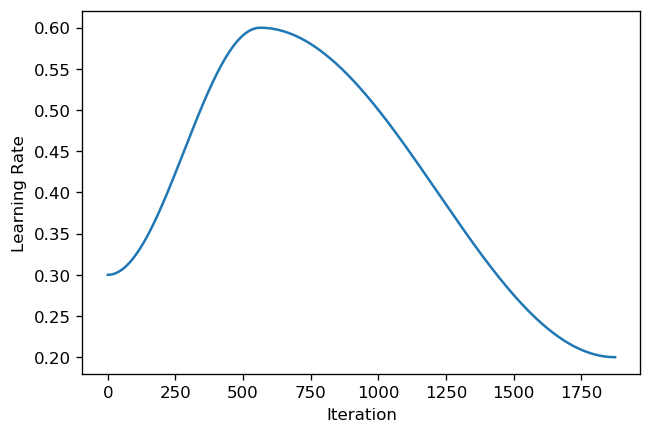

In [96]:
recorder.plotLRs()

The above graph confirms that across all the training iterations of our two epochs, the learning rate did indeed vary according to a combination of cosine annealing warm-up and cool-down schedules.

## 7. BatchNorm

[Original course notebook](https://github.com/fastai/course-v3/blob/master/nbs/swift/07_batchnorm.ipynb)

To implement BatchNorm, we're going to have to workaround some limitations that still currently plague Swift for TensorFlow:
* Some limitations with auto-diff (lack of control flow support).
* Constraints with the `Layer` protocol (the `call` method can't be mutable).

The `Reference` class below will help us to be able to update running statistics without having to make the BatchNorm layer's `call` method `mutating`:

In [97]:
public class Reference<T> {
    public var value: T
    public init(_ value: T) { self.value = value }
}

The `LearningPhaseDependent` protocol will make it possible for us to differentiate a layer's `call` method even if it has different behavior during training vs. during inference, which is certainly the case for all batchnorm layers:

In [98]:
public protocol LearningPhaseDependent: FALayer {
    associatedtype Input
    associatedtype Output
    
    @differentiable func forwardTraining(_ input: Input) -> Output
    @differentiable func forwardInference(_ input: Input) -> Output
}

extension LearningPhaseDependent {
    // Having an @differentiable property on the forward() method is 
    // turns out to be (sometimes) necessary in order for the compiler
    // to know that this extension conforms to FALayer. Frustratingly, 
    // having a @differentiating(forward) method in the extension does 
    // not obviate this requirement.
    @differentiable
    public func forward(_ input: Input) -> Output {
        switch Context.local.learningPhase {
        case .training: return forwardTraining(input)
        case .inference: return forwardInference(input)
        }
    }
    
    @differentiating(forward)
    func gradForward(_ input: Input) -> (value: Output, pullback: (Self.Output.TangentVector) -> 
                                        (Self.TangentVector, Self.Input.TangentVector)) {
        switch Context.local.learningPhase {
        case .training:
            return valueWithPullback(at: input) { $0.forwardTraining($1) }
        case .inference:
            return valueWithPullback(at: input) { $0.forwardInference($1) }
        }
    }
}

In [99]:
public protocol Norm: Layer where Input == Tensor<Scalar>, Output == Tensor<Scalar> {
    associatedtype Scalar
    init(featureCount: Int, ε: Scalar)
}

public struct FABatchNorm<Scalar: TensorFlowFloatingPoint>: LearningPhaseDependent, Norm {
    // TF-603 workaround.
    public typealias Input = Tensor<Scalar>
    public typealias Output = Tensor<Scalar>
    @noDerivative public var delegates: [(Self.Output) -> ()] = []
    
    // Configuring hyperparams
    @noDerivative var momentum, ε: Scalar
    // "running" statistics
    @noDerivative let runningMean, runningVariance: Reference<Tensor<Scalar>>
    // Trainable params
    public var scale, offset: Tensor<Scalar>
    
    public init(featureCount: Int, momentum: Scalar, ε: Scalar = 1e-5) {
        self.momentum = momentum
        self.ε = ε
        self.scale = Tensor(ones: [featureCount])
        self.offset = Tensor(zeros: [featureCount])
        self.runningMean = Reference(Tensor(0))
        self.runningVariance = Reference(Tensor(1))
    }
    
    public init(featureCount: Int, ε: Scalar = 1e-5) {
        self.init(featureCount: featureCount, momentum: 0.9, ε: ε)
    }
    
    @differentiable
    public func forwardTraining(_ input: Tensor<Scalar>) -> Tensor<Scalar> {
        let mean = input.mean(alongAxes: [0, 1, 2])
        let variance = input.variance(alongAxes: [0, 1, 2])
        runningMean.value += (mean - runningMean.value) * (1 - momentum)
        runningVariance.value += (variance - runningVariance.value) * (1 - momentum)
        let normalizer = rsqrt(variance + ε) * scale
        return (input - mean) * normalizer + offset
    }
    
    @differentiable
    public func forwardInference(_ input: Tensor<Scalar>) -> Tensor<Scalar> {
        let mean = runningMean.value
        let variance = runningVariance.value
        let normalizer = rsqrt(variance + ε) * scale
        return (input - mean) * normalizer + offset
    }
}

#### Testing out our Swift batchnorm
In order to test out the above batchnorm implementation, we're gonna move away from a simple, fully-connected 2-layer model that uses flattened MNIST inputs. It's time to start using a convolutional network with MNIST images in their standard, 2-d glory:

In [100]:
// Adds an extra channel (dimension) onto the end of tensors
// containing model inputs. The information stored in MNIST 
// black&white images' single channel will be stored in this 
// dimension. Necessary so that our model inputs will be 
// compatible with the cuDNN library, which expects 2-d images 
// to have 4 dimensions. e.g batchsize X height X width X channel(s)
//
// Note that this is only necessary for MNIST. We won't need to do 
// this for the 3-channel ImageNet images we'll be working with later.
//
// For back&white images the channels dim contains 1 value. 
// For color images this dimension will contain 3 values.
extension Learner {
    public class AddChannel: Delegate {
        public override func batchWillStart(learner: Learner) {
            learner.currentInput = learner.currentInput!.expandingShape(at: -1)
        }
    }
    public func makeAddChannel() -> AddChannel { return AddChannel() }
}

In [101]:
// Creates a single sequence of conv->relu->bn layers
public struct ConvBN<Scalar: TensorFlowFloatingPoint>: FALayer {
    public typealias Input = Tensor<Scalar>
    public typealias Output = Tensor<Scalar>
    @noDerivative public var delegates: [(Self.Output) -> ()] = []
    public var conv: FANoBiasConv2D<Scalar>
    public var bn: FABatchNorm<Scalar>
    
    public init(_ cIn: Int, _ cOut: Int, ks: Int = 3, stride: Int = 1) {
        self.conv = FANoBiasConv2D(cIn, cOut, ks: ks, stride: stride, activation: relu)
        self.bn = FABatchNorm(featureCount: cOut, ε: 1e-5)
    }
    
    @differentiable
    public func forward(_ input: Tensor<Scalar>) -> Tensor<Scalar> {
        return bn.forward(conv.forward(input))
    }
}

In [102]:
// A complete CNN model that has a conv->relu->batchnorm layer
// sequence for each filter that is passed through the 
// <filters> parameter in the init function.
public struct CNN_BN_Model: Layer {
    public var convs: [ConvBN<Float>]
    public var pool = FAGlobalAvgPool2D<Float>()
    public var linear: FADense<Float>
    @noDerivative public var delegates: [(Self.Output) -> ()] = []
    
    public init(cIn: Int, nOut: Int, filters: [Int]) {
        let allFilters = [cIn] + filters
        convs = Array(0..<filters.count).map { i in 
            return ConvBN(allFilters[i], allFilters[i+1], ks: 3, stride: 2)                                 
        }
        linear = FADense<Float>(filters.last!, nOut)
    }
    
    @differentiable
    public func callAsFunction(_ input: TF) -> TF {
        return linear.forward(pool.forward(convs(input)))
    }
}

In [103]:
bs = 64
lr = 4e-1

mnistData = mnistDataBunch(flat: false, bs: bs)

func optFuncSGDCNN(_ model: CNN_BN_Model) -> SGD<CNN_BN_Model> {
    return SGD(for: model, learningRate: lr)
}

func modelInitCNN() -> CNN_BN_Model {
    return CNN_BN_Model(cIn: 1, nOut: 10, filters: [8, 16, 32, 32])
}

var learnCNN = Learner(data: mnistData, lossFunc: softmaxCrossEntropy, optFunc: optFuncSGDCNN, modelInit: modelInitCNN)

var recorderCNN = learnCNN.makeDefaultDelegates(metrics: [accuracy], metricNames: ["Acc"])
learnCNN.addDelegates([learnCNN.makeNormalize(mean: mnistStats.mean, std: mnistStats.std),
                    learnCNN.makeLRScheduler(scheduler: cosineLRSchedule),
                    learnCNN.makeAddChannel()])

In [104]:
learnCNN.fit(2)

         Train Loss | Train Acc | Val Loss | Val Acc |
Epoch 0: 0.0635574   0.9811167   0.0680123   0.9789000                          
Epoch 1: 0.0335591   0.9899333   0.0457502   0.9863000                         


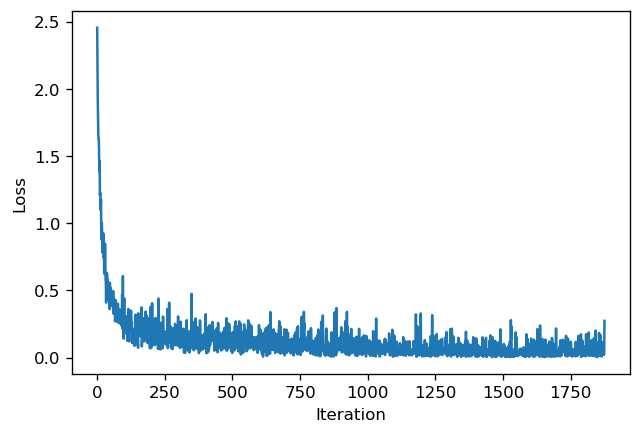

In [105]:
recorderCNN.plotLosses()

## 8. Building the DataBlock API in Swift

[Original course notebook](https://github.com/fastai/course-v3/blob/master/nbs/swift/08_data_block.ipynb)

We've made quite a bit of progress: things like batchnorm, cyclic learning rate schedules, and other callback delegates are now fully working, and we've verified this by building a convolutional network and training it on 2-d MNIST image inputs.

It's time to turn onto the home stretch toward definining and training an XResNet architecture, all in Swift. It's also time to move away from 1-channel MNIST images, and turn our attention to 3-channel ImageNet images. To do this, we'll use 320px-sized images from the [Imagenette](https://github.com/fastai/imagenette) dataset created by Jeremy Howard. Containing images from a small subset of just 10 of the original ImageNet classes, Imagenette makes it possible for researchers to iterate rapidly by performing ImageNet-like experiments that require a small fraction of time and resources that would be needed to train all of ImageNet from scratch.

Since we need to load the Imagenette imageset, now is also a good time to imeplement a Swift version of the fast.ai DataBlock API that we [implemented from scratch](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/08_data_block_my_reimplementation.ipynb?flush_cache=true) in PyTorch in a previous notebook. The spirit of the DataBlock API is that we wish to make it possible for practitioners to perform all the necessary steps to get a dataset ready for model training (labeling, transforms, train-val split, etc.) using a minimum of code and effort. The idea is to hide the complexity and "busy work" of specifying the rote pre-processing steps behind a simple API. 

#### Downloading the Imagenette imageset

In [106]:
public let dataPath = Path.home/".fastai"/"data"

public func downloadImagenette(path: Path = dataPath) -> Path {
    let url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette-320.tgz"
    let fname = "imagenette-320"
    let file = path/fname
    try! path.mkdir(.p)
    if !file.exists {
        downloadFile(url, dest: (path/"\(fname).tgz").string)
        _ = "/bin/tar".shell("-xzf", (path/"\(fname).tgz").string, "-C", path.string)
    }
    return file
}

In [107]:
let path = downloadImagenette()

#### Exploring the Imagenette imageset
The train and val folders:

In [108]:
for o in path.ls() {
    print("\(o.path) (\(o.kind == .directory ? "directory": "file"))")
}

/home/ubuntu/.fastai/data/imagenette-320/val (directory)
/home/ubuntu/.fastai/data/imagenette-320/train (directory)


And the labels of each category in Imagenette:

In [109]:
for o in (path/"val").ls() {
    print("\(o.path) (\(o.kind == .directory ? "directory": "file"))")
}

/home/ubuntu/.fastai/data/imagenette-320/val/n03888257 (directory)
/home/ubuntu/.fastai/data/imagenette-320/val/n03445777 (directory)
/home/ubuntu/.fastai/data/imagenette-320/val/n03425413 (directory)
/home/ubuntu/.fastai/data/imagenette-320/val/n01440764 (directory)
/home/ubuntu/.fastai/data/imagenette-320/val/n03028079 (directory)
/home/ubuntu/.fastai/data/imagenette-320/val/n02979186 (directory)
/home/ubuntu/.fastai/data/imagenette-320/val/n03394916 (directory)
/home/ubuntu/.fastai/data/imagenette-320/val/n02102040 (directory)
/home/ubuntu/.fastai/data/imagenette-320/val/n03417042 (directory)
/home/ubuntu/.fastai/data/imagenette-320/val/n03000684 (directory)


And here's the first ten validation images that belong to the "Tench" category:

In [110]:
let pathTench = path/"val"/"n01440764"
for (index, element) in pathTench.ls().enumerated() {
    if index < 10 {
        print("\(element.path) (\(element.kind == .directory ? "directory": "file"))")
    }
}

/home/ubuntu/.fastai/data/imagenette-320/val/n01440764/ILSVRC2012_val_00017995.JPEG (file)
/home/ubuntu/.fastai/data/imagenette-320/val/n01440764/ILSVRC2012_val_00009379.JPEG (file)
/home/ubuntu/.fastai/data/imagenette-320/val/n01440764/ILSVRC2012_val_00003014.JPEG (file)
/home/ubuntu/.fastai/data/imagenette-320/val/n01440764/ILSVRC2012_val_00048204.JPEG (file)
/home/ubuntu/.fastai/data/imagenette-320/val/n01440764/ILSVRC2012_val_00023559.JPEG (file)
/home/ubuntu/.fastai/data/imagenette-320/val/n01440764/ILSVRC2012_val_00013716.JPEG (file)
/home/ubuntu/.fastai/data/imagenette-320/val/n01440764/ILSVRC2012_val_00025527.JPEG (file)
/home/ubuntu/.fastai/data/imagenette-320/val/n01440764/ILSVRC2012_val_00028158.JPEG (file)
/home/ubuntu/.fastai/data/imagenette-320/val/n01440764/ILSVRC2012_val_00021740.JPEG (file)
/home/ubuntu/.fastai/data/imagenette-320/val/n01440764/ILSVRC2012_val_00017700.JPEG (file)


Now let's write the logic that'll let us view images in the dataset.

In [111]:
// One validation tench image's complete path
let tench_fn = pathTench/"ILSVRC2012_val_00006697.JPEG"

First a brief side-note: we use TensorFlow's [`tf.data` module](https://www.tensorflow.org/api_docs/python/tf/data) to read and resize our Imagenette images before feeding them into the model as training inputs. And since `tf.data` expects these images to be formatted as tensors, the step of reading an image residing at a given file path and converting it to a tensor will be a key part of our image pre-processing pipeline:

In [112]:
public extension StringTensor {
    // Read a file into a Tensor.
    init(readFile filename: String) {
        self.init(readFile: StringTensor(filename))
    }
    
    init(readFile filename: StringTensor) {
        self = Raw.readFile(filename: filename)
    }
    
    // Decode a StringTensor that's holding a JPEG file into a Tensor<UInt8>.
    func decodeJpeg(channels: Int = 0) -> Tensor<UInt8> {
        return Raw.decodeJpeg(contents: self, channels: Int64(channels), dctMethod: "")
    }
}

In [113]:
let decodedImg = StringTensor(readFile: tench_fn.string).decodeJpeg(channels: 3)
print(decodedImg.shape)

[320, 426, 3]


And if we convert this decoded image (which is now a tensor) to numpy, we can use matplotlib to display it:

In [114]:
public func show_img<T: NumpyScalarCompatible>(_ img: Tensor<T>, _ w: Int = 7, 
                                               _ h: Int = 5) {
    show_img(img.makeNumpyArray(), w, h)
}

public func show_img(_ img: PythonObject, _ w: Int = 7, _ h: Int = 5) {
    plt.figure(figsize: [w, h])
    plt.imshow(img)
    plt.axis("off")
    plt.show()
}

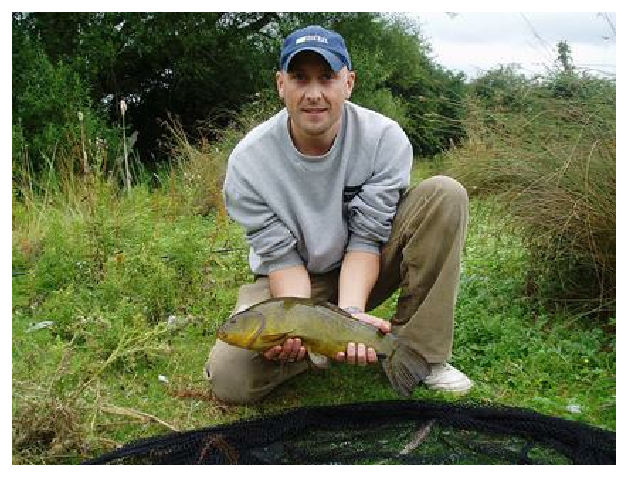

In [115]:
show_img(decodedImg)

#### Convenience function to fetch all the Imagenette images' filenames

In [116]:
public func fetchFiles(path: Path, recurse: Bool = false,
                       extensions: [String]? = nil) -> [Path] {
    var result: [Path] = []
    for p in try! path.ls() {
        if p.kind == .directory && recurse {
            result += fetchFiles(path: p.path, recurse: recurse, extensions: extensions)
        } else if extensions == nil || extensions!.contains(p.path.extension.lowercased()) {
            result.append(p.path)
        }
    }
    return result
}

#### An `ItemList` struct stores paths to all items in the dataset

In [117]:
public struct ItemList<Item> {
    public var items: [Item]
    public let path: Path
    
    public init(items: [Item], path: Path) {
        self.items = items
        self.path = path
    }
}

In [118]:
public extension ItemList where Item == Path {
    
    init(fromFolder path: Path, extensions: [String], recurse: Bool = true) {
        self.init(items: fetchFiles(path: path, recurse: recurse, extensions: extensions),
                  path: path)
    }
}

#### Splitting the data into train and validation sets

In [119]:
public struct SplitData<Item> {
    public let train: ItemList<Item>
    public let valid: ItemList<Item>
    public var path: Path { return train.path }
    
    public init(train: ItemList<Item>, valid: ItemList<Item>) {
        self.train = train
        self.valid = valid
    }
    
    public init(_ il: ItemList<Item>, fromFunc: (Item) -> Bool) {
        self.init(train: ItemList(items: il.items.filter { !fromFunc($0) },
                                  path: il.path),
                  valid: ItemList(items: il.items.filter { fromFunc($0) }, 
                                  path: il.path))
    }
}

In [120]:
public func grandParentSplitter(fname: Path, valid: String = "valid") -> Bool {
    return fname.parent.parent.basename() == valid
}

#### Processors
We will create a `CategoryProcessor` type that can find and return an image's category label.

In [121]:
public protocol Processor {
    associatedtype Input
    associatedtype Output
    
    mutating func initState(items: [Input])
    func process1(item: Input) -> Output
    func deprocess1(item: Output) -> Input
}

In [122]:
public extension Processor {
    func process(items: [Input]) -> [Output] {
        return items.map { process1(item: $0) }
    }
    
    func deprocess(items: [Output]) -> [Input] {
        return items.map { deprocess1(item: $0) }
    }
}

While the `CategoryProcessor` type is used to associate each individual image item with its proper label (input an item and get a numerical category label and vice-versa), in order to make it possible to access not just labels but also the original items from inside a `LabeledItemList`, we also create a `NoopProcessor` type that simply returns the item itself:

In [123]:
public struct NoopProcessor<Item>: Processor {
    public init() {}
    public mutating func initState(items: [Item]) {}
    public func process1(item: Item) -> Item { return item }
    public func deprocess1(item: Item) -> Item { return item }
}

In [124]:
public struct CategoryProcessor: Processor {
    public init() {}
    public var vocab: [String]? = nil
    public var reverseMap: [String: Int32]? = nil
    
    public mutating func initState(items: [String]) {
        vocab = Array(Set(items)).sorted()
        reverseMap = [:]
        for (i,x) in vocab!.enumerated() {
            reverseMap![x] = Int32(i)
        }
    }
    
    public func process1(item: String) -> Int32 {
        return reverseMap![item]!
    }
    
    public func deprocess1(item: Int32) -> String {
        return vocab![Int(item)]
    }
}

#### Use a `LabeledItemList` to hold a labelled dataset
The goal here is to use the processors that were just written above to store the dataset's items and their labels in two separate tensors. The order of the labels must obviously be identical to that of their corresponding items.

In [125]:
public struct LabeledItemList<PI, PL> where PI: Processor, PL: Processor {
    public var items: [PI.Output]
    public var labels: [PL.Output]
    public let path: Path
    public var procItem: PI
    public var procLabel: PL
    
    public init(rawItems: [PI.Input], rawLabels: [PL.Input], path: Path, 
                procItem: PI, procLabel: PL) {
        self.procItem = procItem
        self.procLabel = procLabel
        self.path = path
        self.items = procItem.process(items: rawItems)
        self.labels = procLabel.process(items: rawLabels)
    }
    
    public init(_ il: ItemList<PI.Input>, fromFunc: (PI.Input) -> PL.Input,
                procItem: PI, procLabel: PL) {
        self.init(rawItems: il.items, rawLabels: il.items.map{ fromFunc($0) },
                  path: il.path, procItem: procItem, procLabel: procLabel)
    }
    
    public func rawItem(_ idx: Int) -> PI.Input {
        return procItem.deprocess1(item: items[idx])
    }
    
    public func rawLabel(_ idx: Int) -> PL.Input {
        return procLabel.deprocess1(item: labels[idx])
    }
}

#### Splitting the item/label tensors into train and validation sets

In [126]:
public struct SplitLabeledData<PI,PL> where PI: Processor, PL: Processor {
    public let train: LabeledItemList<PI,PL>
    public let valid: LabeledItemList<PI,PL>
    public var path: Path { return train.path }
    
    public init(train: LabeledItemList<PI,PL>, valid: LabeledItemList<PI,PL>) {
        self.train = train
        self.valid = valid
    }
    
    public init(_ sd: SplitData<PI.Input>, fromFunc: (PI.Input) -> PL.Input, 
                procItem: inout PI, procLabel: inout PL) {
        
        procItem.initState(items: sd.train.items)
        let trainLabels = sd.train.items.map { fromFunc($0) }
        procLabel.initState(items: trainLabels)
        self.init(train: LabeledItemList(rawItems: sd.train.items, rawLabels: trainLabels,
                                         path: sd.path, procItem: procItem, procLabel: procLabel),
                  valid: LabeledItemList(sd.valid, fromFunc: fromFunc, procItem: procItem, 
                                         procLabel: procLabel))
    }
}

A convenience function grabs the name of an item's folder so we can use it as the item's category name:

In [127]:
public func parentLabeler(_ fname: Path) -> String {
    return fname.parent.basename()
}

#### Converting items and labels to tensors

In [128]:
// Converts items (still stored as paths because actually opening 
// the image is a "transform") to a tensor.
public func pathsToTensor(_ paths: [Path]) -> StringTensor {
    return StringTensor(paths.map{ $0.string })
}

// Converts labels to a tensor (category labels are ultimately numeric, 
// in the range of 0 ... <number of categories>)
public func intsToTensor(_ items: [Int32]) -> Tensor<Int32> {
    return Tensor<Int32>(items)
}

#### Storing train/validation data inside a DataBunch
Putting train/val items/labels inside a DataBunch makes it easy for us to access, manage, and verify our dataset in any kind of way we might want (i.e. grab a sample batch, specify which transforms to apply, view classes, etc.), all under one roof.

In [129]:
public struct LabeledElement<I: TensorGroup, L: TensorGroup>: TensorGroup {
    public var xb: I
    public var yb: L
    
    public init(xb: I, yb: L) {
        self.xb = xb
        self.yb = yb
    }
}

In [130]:
public extension SplitLabeledData {
    func toDataBunch<XB, YB>(itemToTensor: ([PI.Output]) -> XB,
                             labelToTensor: ([PL.Output]) -> YB,
                             bs: Int = 64) -> 
    DataBunch<LabeledElement<XB, YB>> where XB: TensorGroup, YB: TensorGroup {
        
        let trainDs = Dataset<LabeledElement<XB, YB>>(
            elements: LabeledElement(xb: itemToTensor(train.items), 
                                     yb: labelToTensor(train.labels)))
        let validDs = Dataset<LabeledElement<XB, YB>>(
            elements: LabeledElement(xb: itemToTensor(valid.items),
                                     yb: labelToTensor(valid.labels)))
        
        return DataBunch(train: trainDs, valid: validDs, 
                         trainLen: train.items.count, 
                         validLen: valid.items.count, bs: bs)
    }
}

#### Applying any other image transforms
Compared to [how we did things with PyTorch](https://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/08_data_block_my_reimplementation.ipynb?flush_cache=true#Executing-the-Data-Block), there's one extra step to creating a DataBunch when using Swift for Tensorflow. Before we can actually pass the images as training inputs for a deep learning model, we're going to need to open and resize all images to the desired size. This is because `tf.data` applies transforms to the imageset *before* it gets fed into the model as inputs. Also, as far as `tf.data` is concerned, *even opening images* at their file paths can be seen as a kind of transform.

The function `transformData` will make it possible to do just this and to specify any other kinds of image transforms we might wish to use. Though for this exercise, we will only open and resize images.

In [131]:
public func transformData<I, TI, L>(_ data: DataBunch<LabeledElement<I, L>>,
                                    nWorkers: Int = 4, tfmItem: (I) -> TI
                                   ) -> DataBunch<DataBatch<TI, L>> 
where I: TensorGroup, TI: TensorGroup & Differentiable, L: TensorGroup {
    return DataBunch(train: data.train.innerDS.map(parallelCallCount: nWorkers){ DataBatch(xb: tfmItem($0.xb), yb: $0.yb) },
                     valid: data.valid.innerDS.map(parallelCallCount: nWorkers){ DataBatch(xb: tfmItem($0.xb), yb: $0.yb) },
                     trainLen: data.train.dsCount,
                     validLen: data.valid.dsCount,
                     bs: data.train.bs)                                                                               
}

In [132]:
public func openAndResize(fname: StringTensor, size: Int) -> TF {
    let decodedImg = StringTensor(readFile: fname).decodeJpeg(channels: 3)
    let resizedImg = Tensor<Float>(Raw.resizeBilinear(
        images: Tensor<UInt8>([decodedImg]),
        size: Tensor<Int32>([Int32(size), Int32(size)]))) / 255.0
    return resizedImg.reshaped(to: TensorShape(size, size, 3))
}

#### To view a batch of images

In [133]:
// Returns a batch of items from a FADataset
public extension FADataset {
    func oneBatch() -> Element? {
        for batch in ds { return batch }
        return nil
    }
}

In [134]:
public func showImages(_ xb: TF, labels: [String]? = nil) {
    let (rows, cols) = (3, 3)
    plt.figure(figsize: [9, 9])
    for i in 0..<(rows * cols) {
        let img = plt.subplot(rows, cols, i + 1)
        img.axis("off")
        let x = xb[i].makeNumpyArray()
        img.imshow(x)
        if labels != nil { img.set_title(labels![i]) }
        if (i + 1) >= (rows * cols) { break }
    }
    plt.show()
}

#### An example: putting the whole Swift DataBlock API together
Now let's actually process Imagenette, store it in a databunch, and train for a few epochs using the simple convolutional + batchnorm architecture we [previously used](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/13_swift_resnet_pipeline_s4tf_v04_my_reimplementation.ipynb#Testing-out-our-Swift-batchnorm) when testing out batchnorm. We'll be resizing the Imagenette images from 320px down to 128px before they are used as model inputs:

In [135]:
// The Swift DataBlock API in action:

let il = ItemList(fromFolder: path, extensions: ["jpeg", "jpg"])
let sd = SplitData(il, fromFunc: {grandParentSplitter(fname: $0, valid: "val")} )
var (procItem, procLabel) = (NoopProcessor<Path>(), CategoryProcessor())
let sld = SplitLabeledData(sd, fromFunc: parentLabeler, procItem: &procItem, procLabel: &procLabel)
var rawData = sld.toDataBunch(itemToTensor: pathsToTensor, labelToTensor: intsToTensor)
let imagenetteData = transformData(rawData) { openAndResize(fname: $0, size: 128) }

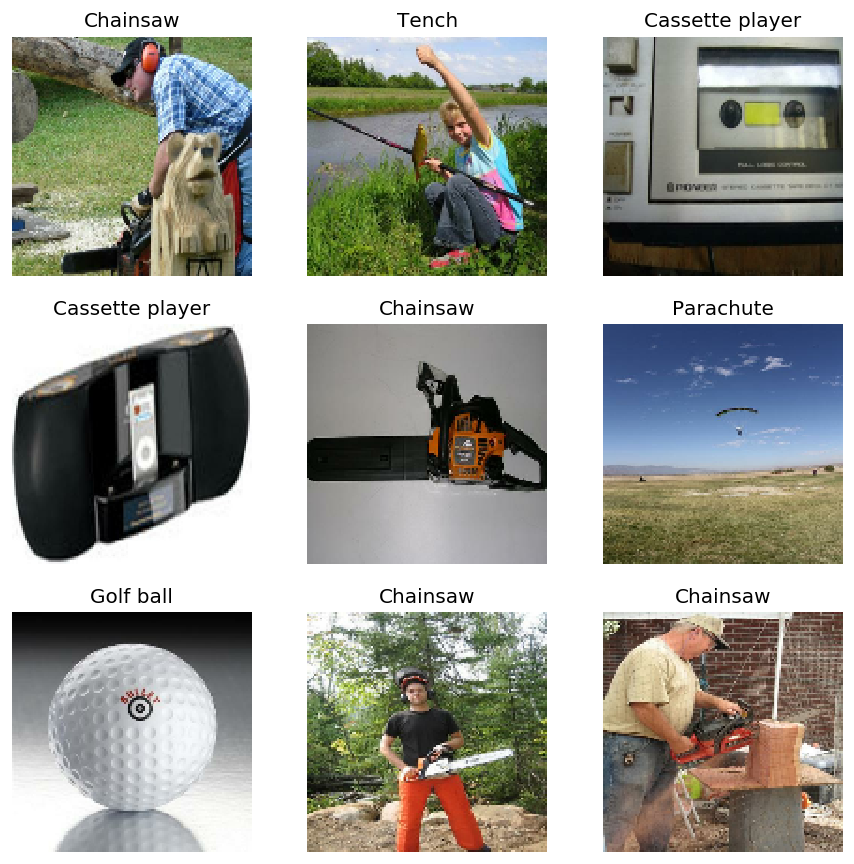

In [136]:
// Get a batch from the above DataBunch
let imagenetteBatch = imagenetteData.train.oneBatch()!

// The Imagenette dataset stores its images in category folders 
// that use the inscrutable ImageNet category codes you can see above. 
// Here's a mapping from each category code to its English name:
let codesToNames = ["n01440764": "Tench", 
                    "n02102040": "English springer",
                    "n02979186": "Cassette player",
                    "n03000684": "Chainsaw", 
                    "n03028079": "Church", 
                    "n03394916": "French horn", 
                    "n03417042": "Garbage truck", 
                    "n03425413": "Gas pump", 
                    "n03445777": "Golf ball", 
                    "n03888257": "Parachute"]
let imagenetteLabels = imagenetteBatch.yb.scalars.map { codesToNames[sld.train.procLabel.vocab![Int($0)]]! }

// Display the first nine images from one batch
showImages(imagenetteBatch.xb, labels: imagenetteLabels)

In [137]:
// We can use the ImageNet dataset's stats to normalize 
// the Imagenette inputs because they originally came from ImageNet.
public let imagenetStats = (mean: TF([0.485, 0.456, 0.406]),
                            std:  TF([0.229, 0.224, 0.225]))

In [138]:
bs = 64
lr = 5e-3

func modelInitCNN_Imagenette() -> CNN_BN_Model {
    return CNN_BN_Model(cIn: 3, nOut: 10, filters: [8, 16, 32, 32])
}

learnCNN = Learner(data: imagenetteData, lossFunc: softmaxCrossEntropy, optFunc: optFuncSGDCNN, modelInit: modelInitCNN_Imagenette)

recorderCNN = learnCNN.makeDefaultDelegates(metrics: [accuracy], metricNames: ["Acc"])
learnCNN.addDelegates([learnCNN.makeNormalize(mean: imagenetStats.mean, std: imagenetStats.std),
                    learnCNN.makeLRScheduler(scheduler: cosineLRSchedule)])

In [139]:
learnCNN.fit(3)

         Train Loss | Train Acc | Val Loss | Val Acc |
Epoch 0: 1.7633452   0.4249263   1.7170520   0.4540000                          
Epoch 1: 1.4703230   0.4987591   1.4586217   0.5120000                          
Epoch 2: 1.2992018   0.5770125   1.3227118   0.5440000                          


## 9. Adam Optimizer

[Original course notebook](https://github.com/fastai/course-v3/blob/master/nbs/swift/09_optimizer.ipynb)

Up until now we've just been using Swift for TensorFlow's defaut SGD optimizer. It would be nice to be able to use an Adam optimizer, especially one that uses the *proper* implementation of weight decay, which for Adam is *not* the same as L2 regularization, [as was discussed](https://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/09_optimizers_my_reimplementation.ipynb?flush_cache=true#Weight-Decay) when we were implementing Adam from scratch in Pytorch. For SGD, the forumulas for L2 regularization and weight decay *are* the same:
```
weight.grad += wd * weight
```

While for Adam our weight decay formula should be: 
```
weight -= lr * (weight.grad + wd*weight)
```

Before we code up Adam, we'll also write a Swift equivalent of the `StatefulOptimizer` class we [wrote in PyTorch](https://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/09_optimizers_my_reimplementation.ipynb?flush_cache=true#Momentum). This class can get and save the most recent state for all weight params that need to be updated during a single step (the gradient params).

Why does saving state matter? As I discussed when we demonstrated the PyTorch version of Adam:
> Stepper algorithms like momentum (which Adam uses) need to be able to access gradients' running averages in order to be able to properly update gradients at a given step. The running average itself must also be updated after each step.

#### Building a Stateful optimizer
First off, defining a type to store all the hyperparameters used by an optimizer will give us tab-complete and thus make it much less likely we'd commit typos/introduce bugs as we go onto actually implement our optimizer:

In [140]:
public struct HyperParams {
    public static let lr = "learningRate"
}

The `StatDelegate` protocol is responsible for computing and updating statistics (such as the average of the gradients) during training that the Adam optimizer needs to know in order to perform weight updates after backprop. 

And the `StepDelegate` protocol is what will actually be in charge of updating the weights.

In PyTorch, we did this by writing classes. Any classes that inherited from these classes would implemented their own modified versions of some of the parent-class' methods. 

In Swift we follow the same spirit, but instead of classes this implementation uses protocols that, as [discussed earlier](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/13_swift_resnet_pipeline_s4tf_v04_my_reimplementation.ipynb#Deep-dive-into-Swift-Protocols), can be conformed to, and or extended.

In [141]:
public protocol StatDelegate {
    var name: String {get}
    var defaultHPs: [String: Float] {get}
    
    func update(_ state: inout [String:TF], p: TF, 𝛁p: TF, hps: inout [String: Float])
}

public protocol StepDelegate {
    var defaultHPs: [String: Float] {get}
    
    func update(_ p: inout TF, 𝛁p: inout TF, state: [String: TF], hps: inout [String: Float])
}

Before we implement the `StatefulOptimizer` class, we should also add some helpful functions and extensions that will make it easier for us to work with dictionaries. Why are dictionaries so important? They're how our optimizer's state is stored during training.

Here is a helper function that we can use to merge one dictionary with each dictionary that's stored in a list (say, when we want all parameter groups to use the same stepper (e.g. momentum) with the same hyperparam values).

An overloaded definition also gives us the flexibility to merge each dictionary inside one list with a dictionary residing at *the same index* inside another list (say, when we want each parameter group to use its own version of a stepper (e.g. momentum), with different hyperparam values for each group).

Recall that a parameter group is just a group of weights from one or more layers that we wish to train using the same hyperparameter values. For instance, in our previous PyTorch [notebook](https://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/11a_transfer_learning_my_reimplementation.ipynb?flush_cache=true#Transfer-Learning-Technique-4:-Discriminative-learning-rates-for-different-parameter-groups) on transfer learning, we used discriminative (different) learning rates to train the weight parameters at different layers in an XResNet (lower layers were trained at a lower learning rate because their weight values transferred more readily -- they had less to learn from the new classification task).

In [142]:
// Merge one dict to each dict stored in a list of dicts.
public func mergeDicts(_ dicts: inout [[String:Float]], with newDict: [String: Float]) {
    for i in dicts.indices {
        dicts[i].merge(newDict) { (_, new) in new }
    }
}

// An overloaded definition that merges merge each dict
// inside one list with the dict residing at the same index 
// in another list of dicts.
public func mergeDicts(_ dicts: inout [[String:Float]], with newDicts: [[String: Float]]) {
    for i in dicts.indices {
        dicts[i].merge(newDicts[i]) { (_, new) in new }
    }
}

The following two extensions to the `Dictionary` protocol make it easier for us to initialize the kinds of dictionaries that our `StatefulOptimizer` will use:

In [143]:
extension Dictionary where Value == Int {
    public init(mapFromArrays arrays: [[Key]]) {
        self.init(uniqueKeysWithValues: arrays.enumerated().flatMap { 
            i, arr in arr.map { ($0, i) } })
    }
}

extension Dictionary {
    public init(constant: Value, keys: [Key]) {
        self.init(uniqueKeysWithValues: keys.map { ($0, constant) })
    }
}

A `StatefulOptimizer()` object can be created by passing a model to the class' `init` method. This object will store all weight parameter groups inside a split array and keep track of the hyperparameter values for each group. The `StatefulOptimizer` class' `update` function is in charge of getting all the `steppers` that update weights and keep the optimizer's state (the values of its `stats`) current.

#### Swift `keyPaths`
To keep track of state and to update parameter weights, the `StatefulOptimizer` class uses a Swift tool called `keyPaths`. Keypaths are nothing more than a quick and handy way to index into nested data structures. In deep learning models, parameter weights sit inside individual layers, which themselves might sit inside modules, which themselves could potentially sit inside parameter groups (a group of layers or modules that all get trained using the same hyperparameter values). This kind of complexity obviously implies a nested data structure, and as such, using keypaths is the most direct way for our optimizer to access and update the values of parameter weights residing at each of a model's layers.

Concretely, the `StatefulOptimizer` loops over `variables.keyPaths` in order to store the state of each layer's gradients. Each layer's state is a dictionary where the `keyPath` is the key and the value is a tensor containing the gradients of all weight parameters that belong to that keypath. The state dictionaries of each parameter group are stored together inside one large split array.

We'll begin by implementing a function that helps create the initial state of a `StatefulOptimizer` object. It's called from inside `StatefulOptimizer`'s `init` function:

In [144]:
public func initState<Model: Layer>(for model: Model, names: [String]) 
-> [WritableKeyPath<Model.AllDifferentiableVariables, TF>: [String: TF]] {
    
    return [WritableKeyPath<Model.AllDifferentiableVariables, TF>: [String: TF]](
        constant: [String: TF](constant: TF(0), keys: names),
        keys: model.variables.keyPaths)
}

And here is the `StatefulOptimizer` class, itself:

In [145]:
public class StatefulOptimizer<Model: Layer>
where Model.AllDifferentiableVariables == Model.TangentVector {
    
    public typealias ModelKeyPath = WritableKeyPath<Model.AllDifferentiableVariables, TF>
    public typealias SplitDict = [ModelKeyPath: Int]
    public var hpGroups: [[String: Float]]
    public var splitDict: SplitDict
    public var states: [ModelKeyPath: [String: TF]]
    public var stats: [StatDelegate]
    public var steppers: [StepDelegate]
    
    public init(for model: __shared Model, steppers: [StepDelegate], stats: [StatDelegate], 
                hpGroups: [[String: Float]], splitArray: [[ModelKeyPath]]) {
        self.hpGroups = Array(repeating: [:], count: hpGroups.count)
        self.steppers = steppers
        self.stats = stats
        self.splitDict = SplitDict(mapFromArrays: splitArray)
        states = [:]
        steppers.forEach { mergeDicts(&self.hpGroups, with: $0.defaultHPs) }
        stats.forEach    { mergeDicts(&self.hpGroups, with: $0.defaultHPs) }
        states = initState(for: model, names: stats.map { $0.name })
        mergeDicts(&self.hpGroups, with: hpGroups)
    }
    
    public func update(_ variables: inout Model.AllDifferentiableVariables, 
                       along direction: Model.TangentVector) {
        for kp in variables.keyPaths {
            var 𝛁p = direction[keyPath: kp]
            var hps = hpGroups[splitDict[kp]!]
            stats.forEach() { $0.update(&states[kp]!, p: variables[keyPath: kp], 𝛁p: 𝛁p, hps: &hps) }
            steppers.forEach() { $0.update(&variables[keyPath: kp], 𝛁p: &𝛁p, state: states[kp]!, hps: &hps) }
            hpGroups[splitDict[kp]!] = hps
        }
    }
}

Two more steps and then our `StatefulOptimizer` will be all set. 

First we need to give it a `learningRate` property and store our `StatefulOptimizer`'s learning rate value inside it. Why? Because our `Recorder` class looks to `Optimizer`'s `learningRate` parameter in order to keep track of and then plot how learning rate varies during training. If we don't do this, we'll break our ability to plot learning rates.

In [146]:
extension StatefulOptimizer: Optimizer {
    public var learningRate: Float {
        get { return hpGroups.last![HyperParams.lr]! }
        set { for i in hpGroups.indices { self.hpGroups[i][HyperParams.lr] = newValue } }
    }
    
    // For discriminative learning rates:
    public var learningRates: [Float] {
        get { return hpGroups.map { $0[HyperParams.lr]! } }
        set { for i in hpGroups.indices { self.hpGroups[i][HyperParams.lr] = newValue[i] } }
    }
}

Second, there will be some situations when we don't have several parameter groups, and instead use one set of hyperparameters to train all the layers of a model. To cover this case, let's add the following `convenience init` function to the `StatefulOptimizer` class:

In [147]:
extension StatefulOptimizer {
    public convenience init(for model: __shared Model, steppers: [StepDelegate],
                            stats: [StatDelegate], hps: [String: Float]) {
        self.init(for: model, steppers: steppers, stats: stats, 
                  hpGroups: [hps], splitArray: [model.variables.keyPaths])
    }
}

#### Weight Decay
Implemented in the way that works best for Adam, as recommended in [Loshchilov and Hutter's](https://arxiv.org/abs/1711.05101) 2017 paper.

In [148]:
public extension HyperParams {
    static let wd = "weightDecay"
}

public struct WeightDecay: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.wd: 0] }
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String: TF], hps: inout [String: Float]) {
        p *= 1 - hps[HyperParams.lr]! * hps[HyperParams.wd]!
    }
}

#### Implementing the Adam Optimizer
For Adam, we need to keep track of several things. First, we care about the average of the gradients:

In [149]:
// Create and store keys for the various items whose states are 
// kept track of and used by our optimizer. A handy way to 
// have autocomplete (typo-proof) available when we actually 
// implement the Adam optimizer.
public struct StateKeys {
    public static let avgGrad = "averageGrad"
}

In [150]:
public extension HyperParams {
    static let mom = "momentum"
    static let momDamp = "dampening"
}

public struct AverageGrad: StatDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.mom: 0.9] }
    public let dampened: Bool
    public init(dampened: Bool = false) { self.dampened = dampened }
    public var name: String { return StateKeys.avgGrad }
    public func update(_ state: inout [String: TF], p: TF, 𝛁p: TF, hps: inout [String: Float]) {
        state[StateKeys.avgGrad]! *= hps[HyperParams.mom]!
        hps[HyperParams.momDamp] = 1.0 - (dampened ? hps[HyperParams.mom]! : 0.0)
        state[StateKeys.avgGrad]! += hps[HyperParams.momDamp]! * 𝛁p
    }
}

As well as the average of squared gradients:

In [151]:
public extension HyperParams {
    static let ²mom = "momentumSquares"
    static let ²momDamp = "dampeningSquares"
}

public extension StateKeys {
    static let avgSqrGrad = "averageSquaredGrad"
}

public struct AverageSquaredGrad: StatDelegate {
    let dampened: Bool
    public init(dampened: Bool = true) { self.dampened = dampened }
    public var name: String { return StateKeys.avgSqrGrad }
    public var defaultHPs: [String: Float] { return [HyperParams.²mom: 0.99] }
    public func update(_ state: inout [String: TF], p: TF, 𝛁p: TF, hps: inout [String: Float]) {
        state[StateKeys.avgSqrGrad]! *= hps[HyperParams.²mom]!
        hps[HyperParams.²momDamp] = 1.0 - (dampened ? hps[HyperParams.²mom]! : 0.0)
        state[StateKeys.avgSqrGrad]! += hps[HyperParams.²momDamp]! * 𝛁p.squared()
    }
}

And we need to keep a count of the number of iterations:

In [152]:
public extension StateKeys {
    static let step = "stepCount"
}

public struct StepCount: StatDelegate {
    public var name: String { return StateKeys.step }
    public var defaultHPs: [String: Float] = [:]
    public init() {}
    public func update(_ state: inout [String: TF], p: TF, 𝛁p: TF, hps: inout [String: Float]) {
        state[StateKeys.step]! += 1.0
    }
}

And we'll need to add the "epsilon" hyperparameter, which is used in Adam, to our `HyperParams` struct that allows us to manage all hyperparameters used by an optimizer:

In [153]:
public extension HyperParams {
    static let ε = "epsilon"
}

The `AdamStep` type puts all of the above together to get us an Adam steppper. By default we don't use weight decay. But a convenience function below right after this will give us the option to add it in.

In [154]:
public struct AdamStep: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.ε: 1e-5] }
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String: TF], hps: inout [String: Float]) {
        let step = state[StateKeys.step]!
        let (mom, damp) = (hps[HyperParams.mom]!, hps[HyperParams.momDamp]!)
        let debias1 = damp * (1 - pow(mom, step)) / (1 - mom)
        let numerator = debias1 * state[StateKeys.avgGrad]!
        
        let (²mom, ²damp) = (hps[HyperParams.²mom]!, hps[HyperParams.²momDamp]!)
        let debias2 = ²damp * (1 - pow(²mom, step)) / (1 - ²mom)
        let denominator = sqrt(state[StateKeys.avgSqrGrad]! / debias2) + hps[HyperParams.ε]!
        
        p -= hps[HyperParams.lr]! * numerator / denominator
    }
}

#### Convenience function to create an Adam Optimizer

In [155]:
public func adamOpt<Model>(lr: Float, mom: Float=0.9, β: Float=0.99, wd: Float=0.0, ε: Float=1e-5
                          ) -> ((Model) -> StatefulOptimizer<Model>) {
    var steppers: [StepDelegate] = [AdamStep()]
    if wd != 0 { steppers.append(WeightDecay()) }
    let stats: [StatDelegate] = [AverageGrad(dampened: true), AverageSquaredGrad(), StepCount()]
    var hps: [String: Float] = [HyperParams.lr: lr]
    hps[HyperParams.mom] = mom
    hps[HyperParams.²mom] = β
    hps[HyperParams.ε] = ε
    if wd != 0 { hps[HyperParams.wd] = wd }
    return {model in 
            return StatefulOptimizer(for: model, steppers: steppers, stats: stats, hps: hps)}
}

#### Scheduling *any* hyperparameter
The `setParam` function below will allow us to schedule any hyperparameters that are inside the optimizer's `hpGroups` dictionaries. Up until now, the `Learner` class only supported learning rate scheduling. Now we generalize it so that any hyperparameter can be scheduled!

In [156]:
public extension StatefulOptimizer {
    func setParam(_ hp: String, _ val: Float) {
        for i in 0..<hpGroups.count { hpGroups[i][hp] = val } 
    }
}

In [157]:
extension Learner where Opt.Scalar: BinaryFloatingPoint,
    Opt.Model.AllDifferentiableVariables == Opt.Model.TangentVector {
    public class ParamScheduler: Delegate {
        public override var order: Int { return 1 }
        public typealias ScheduleFunc = (Float) -> Float
        
        public var scheduler: ScheduleFunc
        public let hp: String
        
        public init(scheduler: @escaping (Float) -> Float, hp: String) {
            (self.scheduler, self.hp) = (scheduler, hp)
        }
        
        override public func batchWillStart(learner: Learner) {
            let val = scheduler(learner.pctEpochs / Float(learner.epochCount))
            (learner.opt as! StatefulOptimizer<Opt.Model>).setParam(hp, val)
        }
    }
        
    public func makeParamScheduler(_ scheduler: @escaping (Float) -> Float, hp: String) -> ParamScheduler {
        return ParamScheduler(scheduler: scheduler, hp: hp)
    }
}

#### The One Cycle Policy
When we built a combined learning rate warm-up and cool-down cosine annealing schedule earlier, we had something that was dangerously close to but not quite the same thing as Leslie Smith's [one cycle policy](https://arxiv.org/abs/1803.09820). The reason was that one cycle also anneals momentum following a course more or less inverse to that of how learning rate changes. Meaning, momentum starts high, cools-down, and then warms back up again toward the end of training.

Now that we can schedule any hyperparameter, we can make a true one cycle training policy that adjusts both learning rate *and* momentum:

In [158]:
public func oneCycleSchedulers(_ lrMax: Float, pctStart: Float=0.25, divStart: Float=10, divEnd: Float=1e5, 
                               moms: (Float,Float,Float) = (0.95,0.85,0.95)) -> ((Float) -> Float, (Float) -> Float) {
    let lrSched = combineSchedules(pcts: [pctStart, 1-pctStart],
                                   schedules: [makeAnnealer(start: lrMax/divStart, end: lrMax, schedule: cosineSchedule),
                                               makeAnnealer(start: lrMax, end: lrMax/divEnd, schedule: cosineSchedule)])
    let momSched = combineSchedules(pcts: [pctStart, 1-pctStart],
                                    schedules: [makeAnnealer(start: moms.0, end: moms.1, schedule: cosineSchedule),
                                                makeAnnealer(start: moms.1, end: moms.2, schedule: cosineSchedule)])
    return (lrSched, momSched)
}

In [159]:
extension Learner where Opt.Scalar: BinaryFloatingPoint, 
    Opt.Model.AllDifferentiableVariables == Opt.Model.TangentVector {
    
    public func addOneCycleDelegates(_ lrMax: Float, pctStart: Float=0.25, divStart: Float=10, divEnd: Float = 1e5,
                                     moms: (Float,Float,Float) = (0.95,0.85,0.95)) {
        let scheds = oneCycleSchedulers(lrMax, pctStart: pctStart, divStart: divStart, divEnd: divEnd, moms: moms)
        addDelegates([makeParamScheduler(scheds.0, hp: HyperParams.lr),
                      makeParamScheduler(scheds.1, hp: HyperParams.mom)])
    }
}

#### Plotting Momentum
Here's a delegate callback that'll keep track of the value of the momentum hyperparameter as it changes from iteration to iteration.

In addition to the `Recorder` delegate class' `plotLRs` function, which we've been using to make sure our learning rates are properly scheduled, we can now also use the `PlotMomentum` delegate class' `plotMoms` method to make sure that the other component of the one cycle policy -- momentum cool-down and warm-up -- is also working properly!

In [160]:
extension Learner where Opt.Model.AllDifferentiableVariables == Opt.Model.TangentVector {
    public class PlotMomentum: Delegate {
        public var moms: [Float] = []
        
        public override func batchDidFinish(learner: Learner) {
            if learner.inTrain {
                // Grab the first parameter group's momentum value
                let mom = (learner.opt as! StatefulOptimizer<Opt.Model>).hpGroups[0][HyperParams.mom]!
                moms.append(mom)
            }
        }
        
        public func plotMoms() {
            plot(Array(0..<moms.count), moms, xLabel: "Iteration", yLabel: "Momentum")
        }
    }
    
    public func makePlotMomentum() -> PlotMomentum {
        return PlotMomentum()
    }
}

#### Testing out Adam and the One Cycle Policy Schedule
To make sure that our Adam optimizer and one cycle schedule policy all work fine, we'll use both to train our simple batchnorm-enabled CNN for a few epochs on Imagenette images:

In [161]:
bs = 64
lr = 1e-3

let optFuncAdamCNN: (CNN_BN_Model) -> StatefulOptimizer<CNN_BN_Model> = adamOpt(lr: lr, mom: 0.9, β: 0.99, wd: 1e-2, ε: 1e-6)

func modelInitAdamCNN() -> CNN_BN_Model {
    return CNN_BN_Model(cIn: 3, nOut: 10, filters: [8, 16, 32, 32])
}

let learnAdamCNN = Learner(data: imagenetteData, lossFunc: softmaxCrossEntropy, optFunc: optFuncAdamCNN, modelInit: modelInitAdamCNN)

// Keep track of training/val loss and accuracy, as well as 
// recording the learning rate used at each iteration.
let recorderAdamCNN = learnAdamCNN.makeDefaultDelegates(metrics: [accuracy], metricNames: ["Acc"])
// Keep track of momentum used at each iteration during training.
let momentumPlotAdamCNN = learnAdamCNN.makePlotMomentum()
learnAdamCNN.addDelegate(momentumPlotAdamCNN)
// Normalize image inputs using ImageNet dataset's statistics
learnAdamCNN.addDelegate(learnAdamCNN.makeNormalize(mean: imagenetStats.mean, std: imagenetStats.std))
// Enable one-cycle lr/mom scheduling
learnAdamCNN.addOneCycleDelegates(lr, pctStart: 0.5)

In [162]:
learnAdamCNN.fit(3)

         Train Loss | Train Acc | Val Loss | Val Acc |
Epoch 0: 1.8586102   0.3618737   1.8134135   0.3920000                         
Epoch 1: 1.6195432   0.4644020   1.5926187   0.4720000                         
Epoch 2: 1.5462376   0.4959671   1.5220875   0.5000000                         


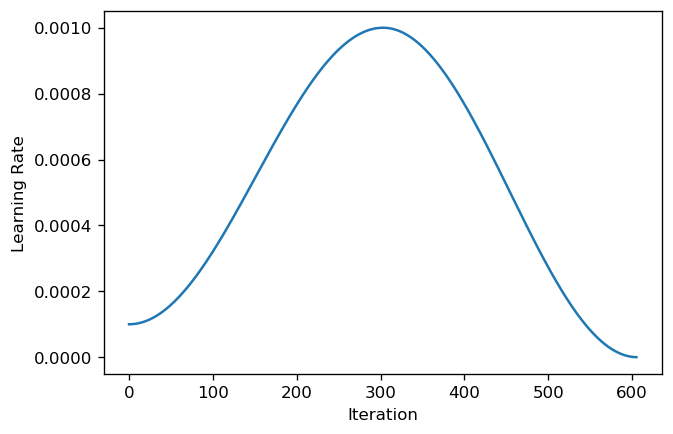

In [163]:
recorderAdamCNN.plotLRs()

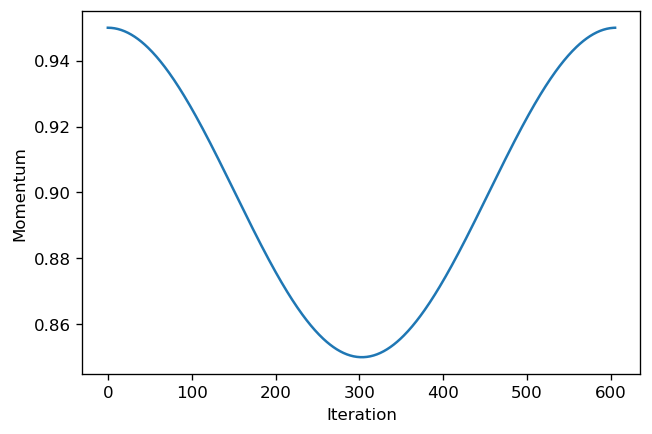

In [164]:
momentumPlotAdamCNN.plotMoms()

Looks great! Learning rate starts at `1e-4`, rises to a maximum of `1e-3` after half of the training iterations, then falls to a minimum of `1e-8` by the end of training, which is exactly what we specified. Momentum falls from `0.95` to `0.85` mid-way through the training cycle, and then rises back to `0.95`, which is also what we intended.

## 11. Training an XResNet on Imagenette

[Original course notebook](https://github.com/fastai/course-v3/blob/master/nbs/swift/11_imagenette.ipynb)

#### Architecting a Flexible and Concise XResNet Implementation
We'll follow the [same approach](https://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/11_train_imagenette_my_reimplementation.ipynb?flush_cache=true) we used in PyTorch.

In [165]:
public struct ConvLayer: Layer {
    public var bn: FABatchNorm<Float>
    public var conv: FANoBiasConv2D<Float>
    
    public init(_ cIn: Int, _ cOut: Int, ks: Int = 3, stride: Int = 1, zeroBn: Bool = false, act: Bool = true) {
        bn = FABatchNorm(featureCount: cOut)
        if act {conv = FANoBiasConv2D(cIn, cOut, ks: ks, stride: stride, activation: relu)}
        else   {conv = FANoBiasConv2D(cIn, cOut, ks: ks, stride: stride, activation: identity)}
        if zeroBn { bn.scale = Tensor(zeros: [cOut]) }
    }
    
    @differentiable
    public func callAsFunction(_ input: TF) -> TF {
        return bn.forward(conv.forward(input))
    }
}

Before we move on to implementing the `ResBlock` and `XResNet` structs, there is one protocol and two types that we need to first define. These serve as a workaround for the fact that Swift autodiff doesn't yet support control flow (if-statements).

We need something as close as possible to control flow for our flexible version of the XResNet architecture because there will be some situations where we'll want to add an average pool or conv layer at a particular layer position, and other situations where we'll not want to do anything at all at that layer's position.

In [166]:
// A layer that can either perform some specific function, or do 
// nothing, in which case it returns exactly what gets passed 
// into it as an input (essentially serving as an identity).
public protocol SwitchableLayer: Layer {
    associatedtype Input
    var isOn: Bool { get set }
    
    @differentiable func forward(_ input: Input) -> Input
}

public extension SwitchableLayer {
    func callAsFunction(_ input: Input) -> Input {
        return isOn ? forward(input) : input
    }
    
    @differentiating(callAsFunction)
    func gradForward(_ input: Input) -> (value: Input, pullback: (Self.Input.TangentVector) -> (Self.TangentVector, Self.Input.TangentVector)) {
        if isOn {
            return valueWithPullback(at: input) { $0.forward($1) }
        } else {
            return (input, { (Self.TangentVector.zero, $0) })
        }
    }
        
}

In [167]:
// Layer that functions as an AvgPool layer, or does nothing.
public struct MaybeAvgPool2D: SwitchableLayer {
    var pool: FAAvgPool2D<Float>
    @noDerivative public var isOn: Bool
    
    @differentiable public func forward(_ input: TF) -> TF { return pool(input) }
    
    public init(_ size: Int) {
        isOn = (size > 1)
        pool = FAAvgPool2D<Float>(size)
    }
}

We want to make a layer type that can either be a normal convolutional layer, or do nothign at all. We'll call this layer `MaybeConv`, and in order to give it the ability to just do nothing and return the identity of whatever it receives as its input, we have to create a fake 1x1x1x1 convolution. Thankfully, using such a matrix won't take up too much memory.

In [168]:
// Layer that functions as a conv layer, or does nothing.
public struct MaybeConv: SwitchableLayer {
    var conv: ConvLayer
    @noDerivative public var isOn: Bool
    
    @differentiable public func forward(_ input: TF) -> TF { return conv(input) }

    public init(_ cIn: Int, _ cOut: Int) {
        isOn = (cIn > 1) || (cOut > 1)
        conv = ConvLayer(cIn, cOut, ks: 1, act: false)
    }
}

Now we can define a ResNet block in a manner nearly identical to how we did using PyTorch:

In [169]:
public struct ResBlock: Layer {
    public var convs: [ConvLayer]
    public var idConv: MaybeConv
    public var pool: MaybeAvgPool2D
    
    public init(_ expansion: Int, _ ni: Int, _ nh: Int, stride: Int = 1){
        let (nf, nin) = (nh*expansion, ni*expansion)
        convs = (expansion == 1) ? [
            ConvLayer(nin, nh, ks: 3, stride: stride),
            ConvLayer(nh, nf, ks: 3, zeroBn: true, act: false)
        ] : [
            ConvLayer(nin, nh, ks: 1),
            ConvLayer(nh, nh, ks: 3, stride: stride),
            ConvLayer(nh, nf, ks: 1, zeroBn: true, act: false)
            
        ]
        idConv = nin == nf ? MaybeConv(1,1) : MaybeConv(nin, nf)
        pool = MaybeAvgPool2D(stride)
    }
    
    @differentiable
    public func callAsFunction(_ input: TF) -> TF {
        return relu(convs(input) + idConv(pool(input)))
    }
}

The `XResNet` struct will also be quite reminiscent of [our approach in PyTorch](https://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/11_train_imagenette_my_reimplementation.ipynb?flush_cache=true#XResNet). Note that we don't have the option of using list comprehensions in swift, so `map` or `reduce` are used instead.

We leave `makeLayer` outside of the `XResNet` struct because we'll need to use it inside the struct's `init` method. In Swift, you can't use a `self` method (a method belonging to a struct) inside the struct's own init unless all attributes have already been properly set. This leads us to a sort of Catch-22 because we actually intend to use `makeLayer` to set the struct's layer attributes. Thus, we leave it outside the struct as in independent helper method.

In [170]:
func makeLayer(_ expansion: Int, _ ni: Int, _ nf: Int, _ nBlocks: Int, stride: Int) -> [ResBlock] {
    return Array(0..<nBlocks).map { ResBlock(expansion, $0 == 0 ? ni : nf, nf, stride: $0 == 0 ? stride : 1) }
}

In [171]:
public struct XResNet: Layer {
    public var stem: [ConvLayer]
    public var maxPool = MaxPool2D<Float>(poolSize: (3,3), strides: (2,2), padding: .same)
    public var blocks: [ResBlock]
    public var pool = GlobalAvgPool2D<Float>()
    public var linear: Dense<Float>
    
    public init(_ expansion: Int, _ layers: [Int], cIn: Int = 3, cOut: Int = 1000){
        var nfs = [cIn, (cIn + 1) * 8, 64, 64]
        stem = (0..<3).map { ConvLayer(nfs[$0], nfs[$0 + 1], stride: $0 == 0 ? 2 : 1) }
        nfs = [64 / expansion, 64, 128, 256, 512]
        blocks = layers.enumerated().map { (i,l) in return makeLayer(expansion, nfs[i], nfs[i+1], l, stride: i==0 ? 1 : 2) }.reduce([], +)
        linear = Dense(inputSize: nfs.last!*expansion, outputSize: cOut)
    }
    
    @differentiable
    public func callAsFunction(_ input: TF) -> TF {
        return input.compose(stem, maxPool, blocks, pool, linear)
    }
}

In just one line, we can use the above two structs to define any kind of XResNet under the sun:

In [172]:
public func xresnet18 (cIn: Int = 3, cOut: Int = 1000) -> XResNet { return XResNet(1, [2, 2, 2, 2], cIn: cIn, cOut: cOut) }
public func xresnet34 (cIn: Int = 3, cOut: Int = 1000) -> XResNet { return XResNet(1, [3, 4, 6, 3], cIn: cIn, cOut: cOut) }
public func xresnet50 (cIn: Int = 3, cOut: Int = 1000) -> XResNet { return XResNet(4, [3, 4, 6, 3], cIn: cIn, cOut: cOut) }
public func xresnet101(cIn: Int = 3, cOut: Int = 1000) -> XResNet { return XResNet(4, [3, 4, 23, 3], cIn: cIn, cOut: cOut) }
public func xresnet152(cIn: Int = 3, cOut: Int = 1000) -> XResNet { return XResNet(4, [3, 8, 36, 3], cIn: cIn, cOut: cOut) }

#### Training an XResNet34
Recall that `modelInitXResNet34` is just a closure that returns our model. We pass this function to the `model` argument when creating a `Learner` object:

In [173]:
bs = 64
lr = 1e-4

func modelInitXResNet34() -> XResNet { return xresnet34(cOut: 10) }
let optFuncAdamXResNet34: (XResNet) -> StatefulOptimizer<XResNet> = adamOpt(lr: lr, mom: 0.9, β: 0.99, wd: 1e-2, ε: 1e-6)
let learnerXResNet34 = Learner(data: imagenetteData, lossFunc: softmaxCrossEntropy, optFunc: optFuncAdamXResNet34, modelInit: modelInitXResNet34)
// Keep track of training/val loss and accuracy during training.
let recorderXResNet34 = learnerXResNet34.makeDefaultDelegates(metrics: [accuracy], metricNames: ["Acc"])
// Normalize image inputs using ImageNet dataset's statistics
learnerXResNet34.addDelegate(learnerXResNet34.makeNormalize(mean: imagenetStats.mean, std: imagenetStats.std))
// Enable one-cycle lr/mom scheduling
learnerXResNet34.addOneCycleDelegates(lr, pctStart: 0.5)

In [174]:
learnerXResNet34.fit(20)

         Train Loss | Train Acc | Val Loss | Val Acc |
Epoch 0: 2.0658312   0.2474019   2.0423560   0.2400000                          
Epoch 1: 1.8207159   0.3877773   1.8010309   0.4180000                          
Epoch 2: 1.6212780   0.4847216   1.5987794   0.5060000                          
Epoch 3: 1.3812304   0.5815108   1.3884236   0.5880000                          
Epoch 4: 1.1386050   0.6545680   1.1498150   0.6660000                          
Epoch 5: 0.9461539   0.7073833   1.0147537   0.6980000                          
Epoch 6: 0.8128230   0.7448426   0.8983270   0.7160000                          
Epoch 7: 0.6636387   0.7892818   0.8012580   0.7400000                          
Epoch 8: 0.5784401   0.8165038   0.8202875   0.7340000                          
Epoch 9: 0.4103528   0.8778502   0.7334105   0.7720000                          
Epoch 10: 0.2788646   0.9259346   0.6420715   0.8160000                         
Epoch 11: 0.2064061   0.9512176   0.6901335   0.780000

To see how our results stack up, if you visit the Imagenette [leaderboard](https://github.com/fastai/imagenette#imagenette-1), you'll notice that the best performing model that, like us above, trained on size 128px images for 20 epochs had a validation accuracy of 92%. We didn't make it this high, but if you look at the [script](https://github.com/fastai/fastai/blob/master/examples/train_imagenette.py) used to train that model, you'll see that they used an XResNet50 architecture. 

And thus we conclude our Swift for TensorFlow journey. We've learned how to build everything we'll need, such as batchnorm, callbacks, and hyperparameter scheduling, to train a fairly modern architecture using modern techniques. I hope this has been an educational journey for you, and I'm excited to see how Swift for TensorFlow will evolve over the next two years. Specifically, I'm anxious to see what it will be like to have the [MLIR compiler](https://github.com/tensorflow/mlir) serve as the compiler for Swift for TensforFlow!